<a href="https://colab.research.google.com/github/luthfiyahastutiningtyas/Auto-ARIMA-PSO-LSTM-GRU/blob/main/TBIG-Auto_ARIMA%2C_PSO_LSTM_%26_PSO_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Install Library yang Dibutuhkan**

In [ ]:
!pip install pmdarima
!pip install pyswarm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a1209ce5c2578f7512d354858974d3bb1601f014f73a8ab54c1f1547648d4ad4
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import yfinance as yf
from pmdarima import auto_arima
from pyswarm import pso
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import date, datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Data**

In [ ]:
stocks = ["TLKM.JK", "TBIG.JK", "TOWR.JK"]
start_date =  "2014-01-01"
end_date = "2024-01-01"
data = yf.download(stocks, start=start_date, end=end_date)
data.head(5)

[*********************100%%**********************]  3 of 3 completed


Price        Adj Close                            Close                  \
Ticker         TBIG.JK      TLKM.JK     TOWR.JK TBIG.JK TLKM.JK TOWR.JK   
Date                                                                      
2014-01-02  965.110840  1541.423340  429.595886  1210.0  2175.0   540.0   
2014-01-03  957.134705  1505.988525  429.595886  1200.0  2125.0   540.0   
2014-01-06  965.110840  1477.640381  429.595886  1210.0  2085.0   540.0   
2014-01-07  965.110840  1467.009888  426.413727  1210.0  2070.0   536.0   
2014-01-08  989.039185  1488.270996  429.595886  1240.0  2100.0   540.0   

Price         High                     Low                    Open          \
Ticker     TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK TOWR.JK TBIG.JK TLKM.JK   
Date                                                                         
2014-01-02  1210.0  2200.0   540.0  1160.0  2150.0   540.0  1180.0  2175.0   
2014-01-03  1220.0  2175.0   540.0  1160.0  2100.0   540.0  1210.0  2125.0   
2014-01-06  1220.0  2175.0   540.0  1170.0  2065.0   540.0  1220.0  2175.0   
2014-01-07  1215.0  2085.0   536.0  1180.0  2060.0   520.0  1200.0  2085.0   
2014-01-08  1245.0  2100.0   545.0  1200.0  2065.0   534.0  1200.0  2085.0   

Price                 Volume                        
Ticker     TOWR.JK   TBIG.JK     TLKM.JK   TOWR.JK  
Date                                                
2014-01-02   540.0   7512500  44446000.0   50000.0  
2014-01-03   540.0   8992500  60001000.0  280000.0  
2014-01-06   540.0  10958500  81736300.0  610500.0  
2014-01-07   520.0   6029500  73637100.0  212500.0  
2014-01-08   536.0  16130000  84514500.0  246500.0

## **Preprocessing Data**

In [ ]:
df_close = data.Close
list(df_close)
df_close.columns = ['TBIG', 'TLKM', 'TOWR']
df_close.head(5)

,TBIG,TLKM,TOWR
Date,,,
2014-01-02,1210.0,2175.0,540.0
2014-01-03,1200.0,2125.0,540.0
2014-01-06,1210.0,2085.0,540.0
2014-01-07,1210.0,2070.0,536.0
2014-01-08,1240.0,2100.0,540.0


In [ ]:
#statistik deskriptif
df_close.describe()

,TBIG,TLKM,TOWR
count,2482.000000,2481.000000,2481.000000
mean,1622.887591,3617.390165,870.474809
std,677.014073,620.277928,193.823144
min,610.000000,2070.000000,119.199997
25%,1140.000000,3130.000000,755.000000
50%,1325.000000,3760.000000,810.000000
75%,2050.000000,4090.000000,1015.000000
max,3400.000000,4800.000000,1590.000000


In [ ]:
#Periksa tipe data
print(df_close.dtypes)

TBIG    float64
TLKM    float64
TOWR    float64
dtype: object


In [ ]:
# Cek data hilang
data_hilang=df_close.isnull()
missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    1
TOWR    1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2481 non-null   float64
 2   TOWR    2481 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


In [ ]:
from IPython.core.display import clear_output
# Menghapus baris yang mengandung nilai NaN
modus_tlkm = df_close['TLKM'].mode()[0]
df_close['TLKM'].fillna(modus_tlkm, inplace=True)
modus_towr = df_close['TOWR'].mode()[0]
df_close['TOWR'].fillna(modus_towr, inplace=True)

clear_missing = df_close.isnull().sum()
print(f"Jumlah data hilang: {clear_missing}")
df_close.info()

Jumlah data hilang: TBIG    0
TLKM    0
TOWR    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 2014-01-02 to 2023-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TBIG    2482 non-null   float64
 1   TLKM    2482 non-null   float64
 2   TOWR    2482 non-null   float64
dtypes: float64(3)
memory usage: 77.6 KB


<ipython-input-8-9cb536d8d3f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TLKM'].fillna(modus_tlkm, inplace=True)
<ipython-input-8-9cb536d8d3f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['TOWR'].fillna(modus_towr, inplace=True)


In [ ]:
# Periksa apakah ada tanggal yang duplikat
duplicate_dates = df_close[df_close.index.duplicated(keep=False)]
print("Tanggal duplikat:\n", duplicate_dates)

Tanggal duplikat:
 Empty DataFrame
Columns: [TBIG, TLKM, TOWR]
Index: []


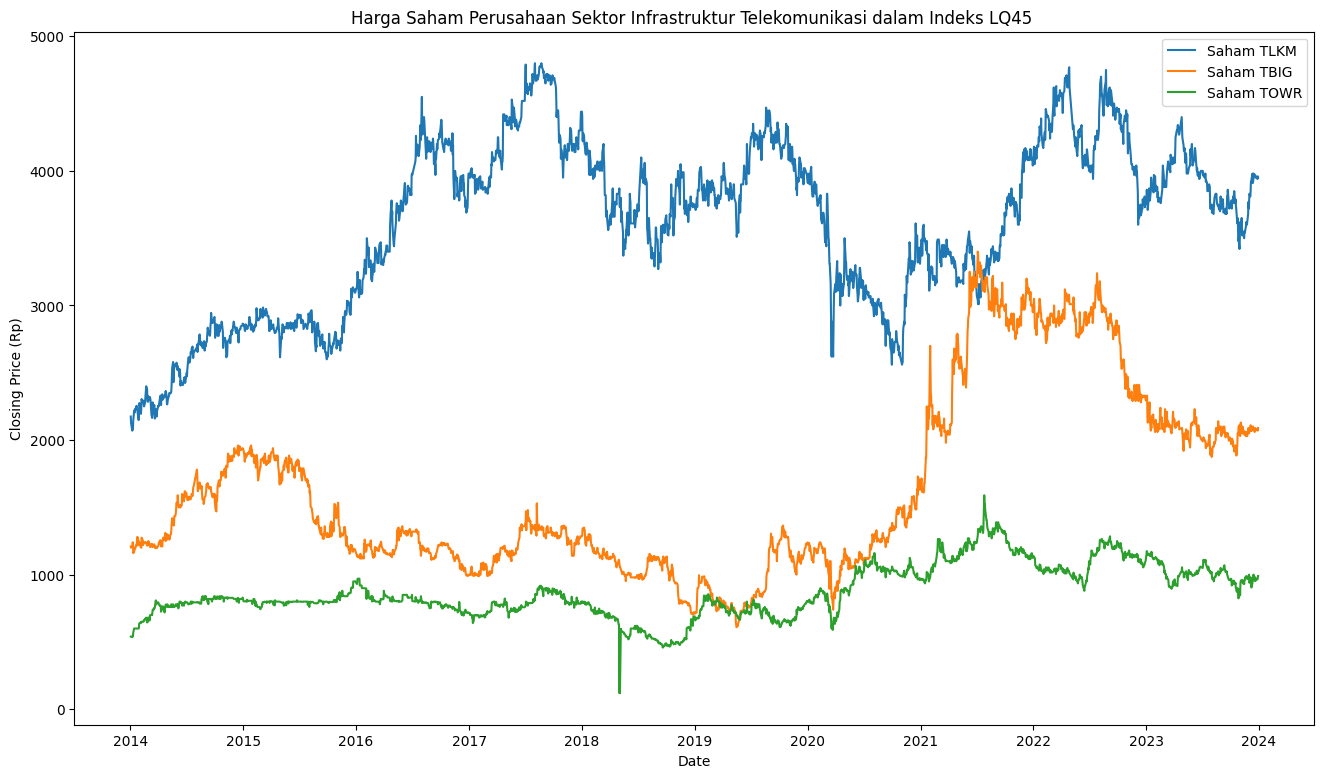

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(16,9))
for name in ['TLKM', 'TBIG', 'TOWR']:
    ax.plot(df_close[name].index, df_close[name], label='Saham {}'.format(name))

ax.set_title('Harga Saham Perusahaan Sektor Infrastruktur Telekomunikasi dalam Indeks LQ45 ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (Rp)')
ax.legend()

In [ ]:
split_data = df_close.shape[0] * 0.8

df_train = df_close[:int(split_data)]
df_test = df_close[int(split_data):]

#Checking dataset shape
print("df_train: ", df_train.shape)
print(df_train)
print("df_test: ", df_test.shape)
print(df_test)

df_train:  (1985, 3)
              TBIG    TLKM    TOWR
Date                              
2014-01-02  1210.0  2175.0   540.0
2014-01-03  1200.0  2125.0   540.0
2014-01-06  1210.0  2085.0   540.0
2014-01-07  1210.0  2070.0   536.0
2014-01-08  1240.0  2100.0   540.0
...            ...     ...     ...
2021-12-08  3080.0  4090.0  1130.0
2021-12-09  3180.0  4150.0  1135.0
2021-12-10  3200.0  4150.0  1145.0
2021-12-13  3140.0  4080.0  1145.0
2021-12-14  3100.0  4100.0  1125.0

[1985 rows x 3 columns]
df_test:  (497, 3)
              TBIG    TLKM    TOWR
Date                              
2021-12-15  3090.0  4080.0  1130.0
2021-12-16  3130.0  4100.0  1120.0
2021-12-17  3090.0  4100.0  1115.0
2021-12-20  3090.0  4080.0  1140.0
2021-12-21  3040.0  4160.0  1140.0
...            ...     ...     ...
2023-12-21  2070.0  3950.0   955.0
2023-12-22  2080.0  3960.0   965.0
2023-12-27  2080.0  3940.0   965.0
2023-12-28  2070.0  3960.0   970.0
2023-12-29  2090.0  3950.0   990.0

[497 rows x 3 columns]


---
# **PT. Tower Bersama Infrastructure Tbk (TBIG)**
---

###**Splitting Data**

In [ ]:
#Split Dataset Training 80% & Testing 20%

data_tbig = df_close['TBIG']
data_tbig.index=data_tbig.index.date
split_data = data_tbig.shape[0] * 0.8

df_train_tbig = data_tbig[:int(split_data)]
df_test_tbig = data_tbig[int(split_data):]

#Checking dataset shape
print("df_train_tbig: ", df_train_tbig.shape)
print(df_train_tbig)
print("df_test_tbig: ", df_test_tbig.shape)
print(df_test_tbig)

df_train_tbig:  (1985,)
2014-01-02    1210.0
2014-01-03    1200.0
2014-01-06    1210.0
2014-01-07    1210.0
2014-01-08    1240.0
               ...  
2021-12-08    3080.0
2021-12-09    3180.0
2021-12-10    3200.0
2021-12-13    3140.0
2021-12-14    3100.0
Name: TBIG, Length: 1985, dtype: float64
df_test_tbig:  (497,)
2021-12-15    3090.0
2021-12-16    3130.0
2021-12-17    3090.0
2021-12-20    3090.0
2021-12-21    3040.0
               ...  
2023-12-21    2070.0
2023-12-22    2080.0
2023-12-27    2080.0
2023-12-28    2070.0
2023-12-29    2090.0
Name: TBIG, Length: 497, dtype: float64


---
## **Auto ARIMA**
---

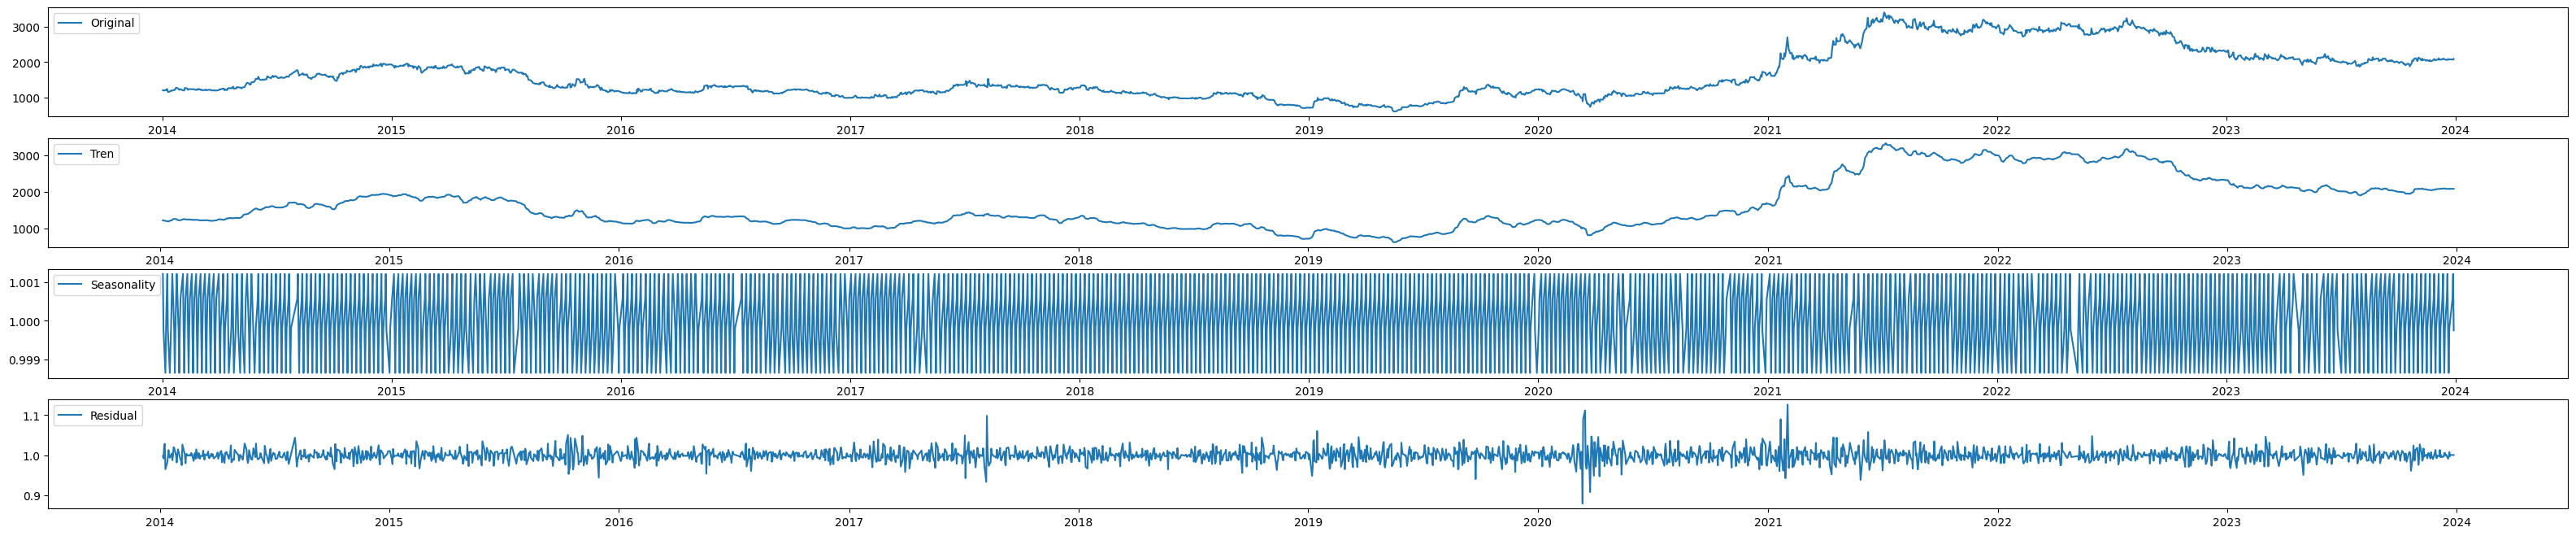

In [ ]:
#Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(data_tbig, model='multiplicative', period=5)  # Atau 'multiplicative'
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid
fig, ax = plt.subplots(4, 1, figsize=(40, 8))
ax[0].plot(data_tbig, label='Original')
ax[0].legend(loc='upper left')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='upper left')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='upper left')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='upper left')
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(df_train_tbig, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                    0.097674
p-value                           0.965902
#Lags Used                       10.000000
Number of Observations Used    1974.000000
Critical Value (1%)              -3.433667
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64


p-value sebesar 0.965902 lebih dari 0.05 maka data tidak stasioner

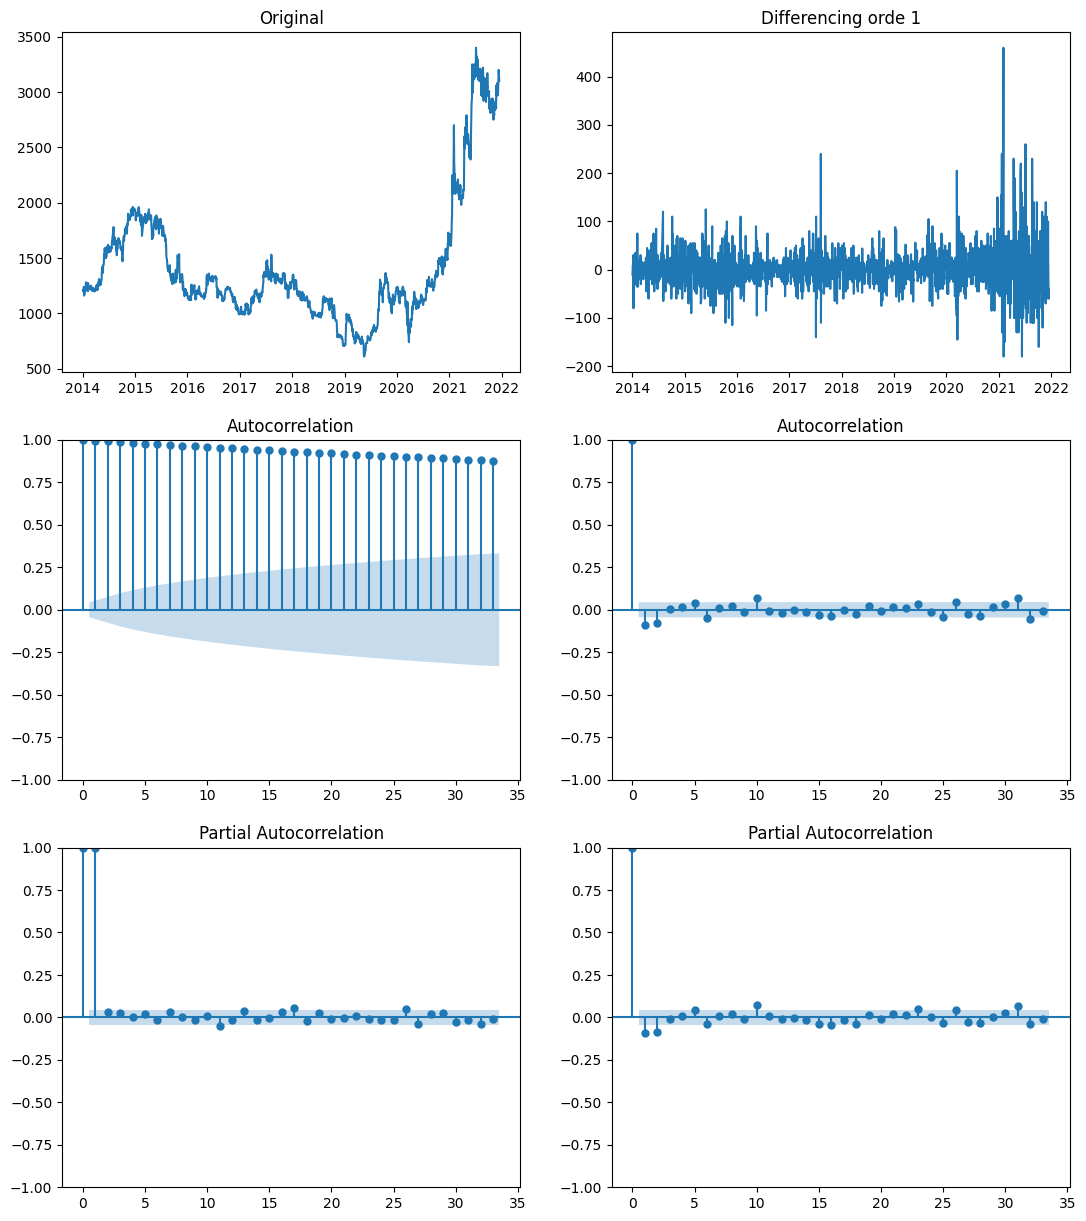

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(13,15))
axes[0, 0].plot(df_train_tbig)
axes[0, 0].set_title('Original')
#Differencing orde 1
axes[0, 1].plot(df_train_tbig.diff())
axes[0, 1].set_title('Differencing orde 1')

#ACF plot untuk menentukan q (MA)
plot_acf(df_train_tbig, ax=axes[1, 0])
plot_acf(df_train_tbig.diff().dropna(), ax=axes[1, 1])

#PACF plot untuk menentukan p (AR)
plot_pacf(df_train_tbig, ax=axes[2,0])
plot_pacf(df_train_tbig.diff().dropna(), ax=axes[2,1])

plt.show()

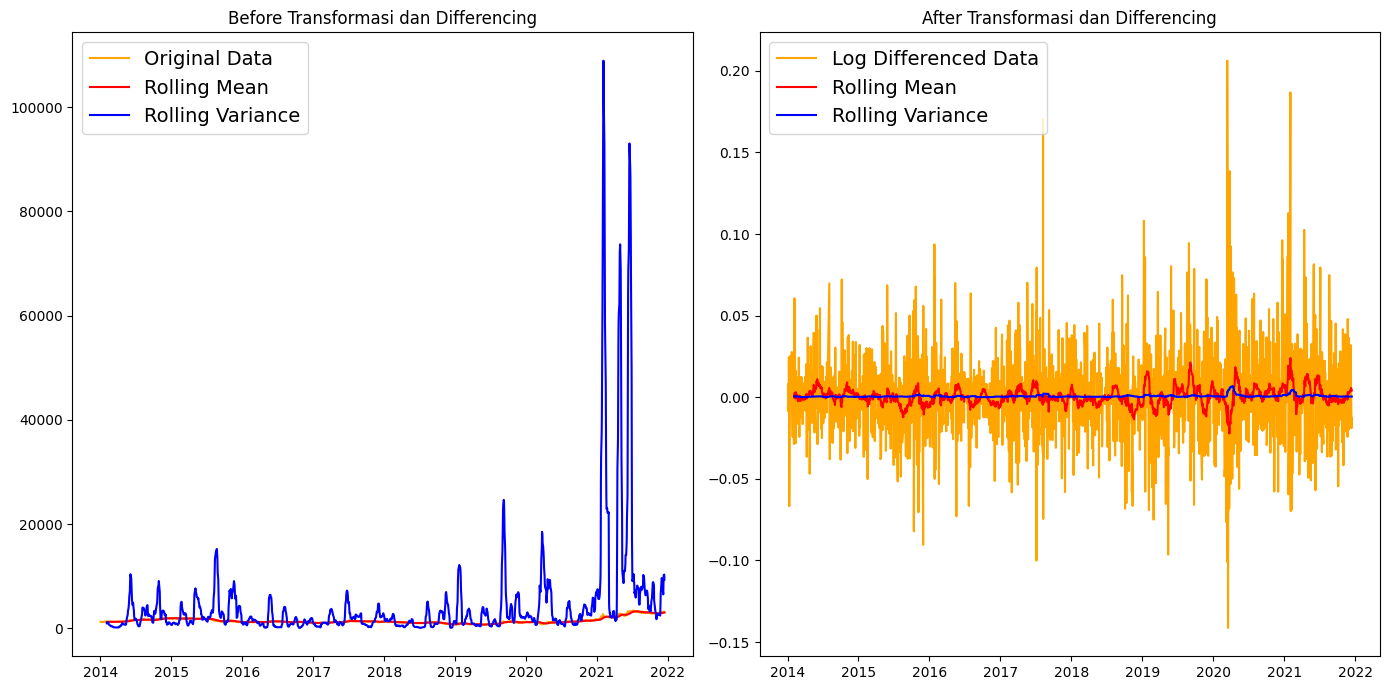

In [ ]:
#Rolling mean dan rolling varians
rolling_mean = df_train_tbig.rolling(21).mean()
rolling_var = df_train_tbig.rolling(21).var()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(df_train_tbig, color='orange', label='Original Data')
ax[0].plot(rolling_mean, color='red', label='Rolling Mean')
ax[0].plot(rolling_var, color='blue', label='Rolling Variance')
ax[0].set_title('Before Transformasi dan Differencing')
ax[0].legend(loc='upper left', fontsize=14)

# Transformasi logaritmik
data_log = np.log(df_train_tbig)
data_log_diff = data_log.diff().dropna()

#Rolling mean dan rolling varians
rolling_mean = data_log_diff.rolling(21).mean()
rolling_var = data_log_diff.rolling(21).var()

ax[1].plot(data_log_diff, color='orange', label='Log Differenced Data')
ax[1].plot(rolling_mean, color='red', label='Rolling Mean')
ax[1].plot(rolling_var, color='blue', label='Rolling Variance')
ax[1].set_title('After Transformasi dan Differencing')
ax[1].legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#Differencing orde 1
df_test = adfuller(data_log_diff, autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.314108e+01
p-value                        1.428975e-24
#Lags Used                     9.000000e+00
Number of Observations Used    1.974000e+03
Critical Value (1%)           -3.433667e+00
Critical Value (5%)           -2.863005e+00
Critical Value (10%)          -2.567550e+00
dtype: float64


p-value sebesar 0.0000 kurang dari 0.05 maka data stasioner

In [ ]:
start_time = time.time()
Model_auto_arima = auto_arima(data_log,
                                 trace=True,
                                 stepwise=True,
                                 error_action='ignore',
                                 supress_warnings=True,
                                 seasonal=False,
                                 stationary=False,
                                 start_p=0,
                                 start_q=0,
                                 d=1,
                                 max_p=5,
                                 max_q=5,
                                 method='bfgs'
                                 )
end_time = time.time()
Model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8923.036, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8935.994, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8937.236, Time=2.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8924.351, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8936.591, Time=14.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8937.304, Time=11.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8935.537, Time=14.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8936.123, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8934.021, Time=8.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8938.403, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8938.391, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8936.793, Time=1.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-8937.258, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8937.701, Time=0.39 sec
 ARIMA(1,1,3)(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1985
Model:               SARIMAX(0, 1, 2)   Log Likelihood                4472.202
Date:                Tue, 13 Aug 2024   AIC                          -8938.403
Time:                        06:21:31   BIC                          -8921.625
Sample:                             0   HQIC                         -8932.240
                               - 1985                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0889      0.014     -6.189      0.000      -0.117      -0.061
ma.L2         -0.0315      0.015     -2.152      0.031      -0.060      -0.003
sigma2         0.0006   1.02e-05     63.520      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3682.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
fitted = Model_auto_arima.predict_in_sample()
fitted_values = np.exp(fitted)

In [ ]:
import statsmodels.api as sm
residuals = Model_auto_arima.resid()
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[2], return_df=True)
print('Ljung-Box Test Results:')
print(ljung_box_results)

Ljung-Box Test Results:
    lb_stat  lb_pvalue
2  0.004681   0.997662


Nilai lb_pvalue sebesar 0.997662 lebih besar dari 0.05 menunjukkan bahwa model Auto ARIMA berhasil menangkap semua pola dalam data dan residual dari model tersebut adalah white noise.

In [ ]:
prediksi = Model_auto_arima.predict(n_periods= len(df_test_tbig))
prediksi_autoarima = np.exp(prediksi)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


####**Evaluasi Model**



In [ ]:
#Evaluasi Train Data
r2_train_autoarima = r2_score(df_train_tbig, fitted_values)
rmse_train_autoarima = np.sqrt(mse(df_train_tbig, fitted_values))
mape_train_autoarima = mape(df_train_tbig, fitted_values) * 100
print('R2 pada Train Data :', r2_train_autoarima)
print('RMSE pada Train Data :', rmse_train_autoarima)
print('MAPE pada Train Data :', mape_train_autoarima)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_autoarima = r2_score(df_test_tbig, prediksi_autoarima)
rmse_test_autoarima = np.sqrt(mse(df_test_tbig, prediksi_autoarima))
mape_test_autoarima = mape(df_test_tbig, prediksi_autoarima) * 100
print('R2 pada Train Data :', r2_test_autoarima)
print('RMSE pada Train Data :', rmse_test_autoarima)
print('MAPE pada Train Data :', mape_test_autoarima)
print("------------------------------------------")
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9927430225062531
RMSE pada Train Data : 47.96122119845626
MAPE pada Train Data : 1.7675787182356941
------------------------------------------
R2 pada Train Data : -2.566283969931186
RMSE pada Train Data : 775.509635044997
MAPE pada Train Data : 30.446014383308324
------------------------------------------
Training time: 57.55631732940674


####**Comparison Real vs Prediction**

In [ ]:
tabel_fitted_autoarima = pd.DataFrame({'Date': df_train_tbig.index,  'Data Train': df_train_tbig.values, 'Fitted Values':  fitted_values})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_fitted.csv'
tabel_fitted_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_fitted.csv')
tabel_fitted_autoarima

,Date,Data Train,Fitted Values
0,2014-01-02,1210.0,1.000000
1,2014-01-03,1200.0,1210.000000
2,2014-01-06,1210.0,1200.849982
3,2014-01-07,1210.0,1209.499199
4,2014-01-08,1240.0,1209.667030
...,...,...,...
1980,2021-12-08,3080.0,3044.431706
1981,2021-12-09,3180.0,3075.160900
1982,2021-12-10,3200.0,3169.381019
1983,2021-12-13,3140.0,3193.896560


In [ ]:
tabel_prediksi_autoarima = pd.DataFrame({'Date':df_test_tbig.index, 'Test' : df_test_tbig.values, 'Prediksi Auto ARIMA': prediksi_autoarima})
folder_autoarima = '/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_results.csv'
tabel_prediksi_autoarima.to_csv(folder_autoarima, index=False, mode='w')
tabel_prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_results.csv')
tabel_prediksi_autoarima

,Date,Test,Prediksi Auto ARIMA
0,2021-12-15,3090.0,3105.530385
1,2021-12-16,3130.0,3106.901474
2,2021-12-17,3090.0,3106.901474
3,2021-12-20,3090.0,3106.901474
4,2021-12-21,3040.0,3106.901474
...,...,...,...
492,2023-12-21,2070.0,3106.901474
493,2023-12-22,2080.0,3106.901474
494,2023-12-27,2080.0,3106.901474
495,2023-12-28,2070.0,3106.901474


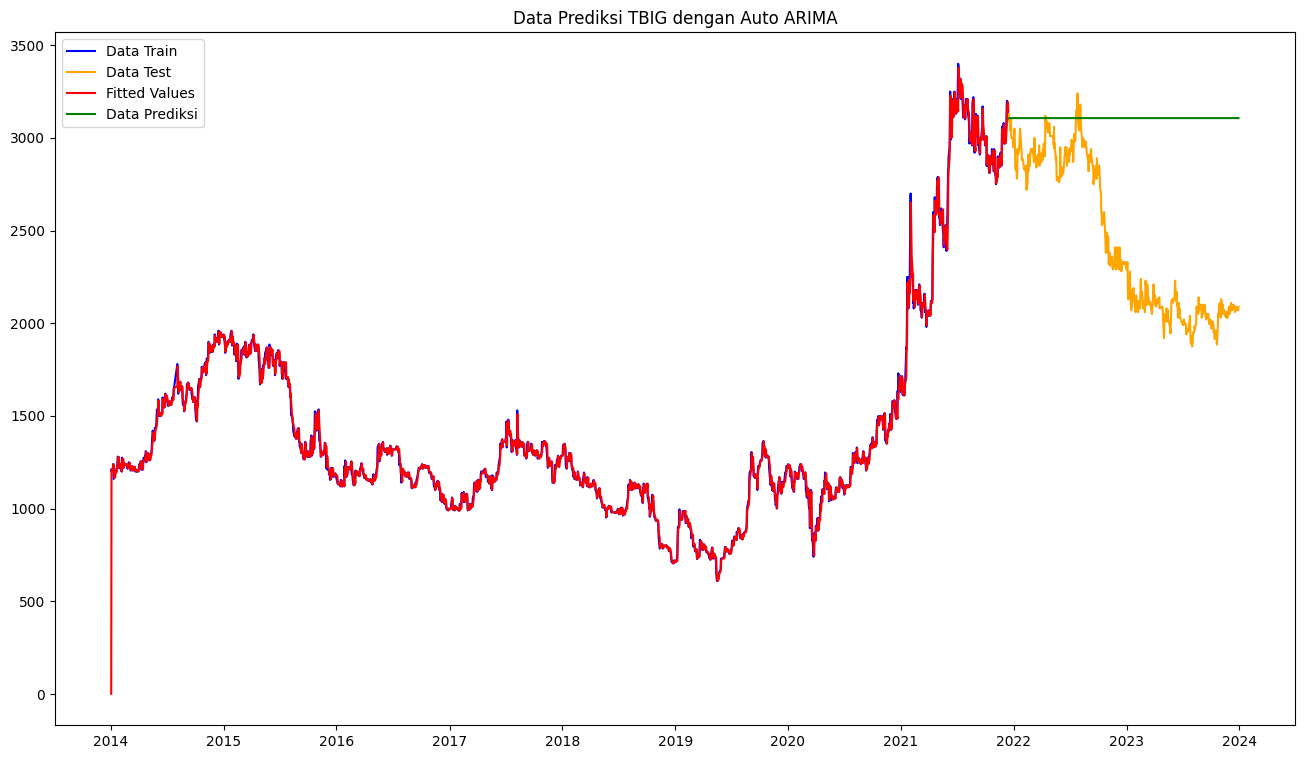

In [ ]:
#Plot data prediksi
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="blue", label='Data Train')
plt.plot(df_test_tbig, color="orange", label='Data Test')
plt.plot(df_train_tbig.index, fitted_values, color="red", label='Fitted Values')
plt.plot(df_test_tbig.index, prediksi_autoarima, color="green",  label='Data Prediksi')
plt.title('Data Prediksi TBIG dengan Auto ARIMA')
plt.legend(loc="upper left")

plot_auto_arima = '/content/drive/My Drive/skripsi/auto arima/auto_arima_tbig.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_auto_arima)
plt.show()


---
## **LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tbig, df_test_tbig):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tbig_norm = scaler.fit_transform(df_train_tbig.values.reshape(-1,1))
  test_data_tbig_norm = scaler.transform(df_test_tbig.values.reshape(-1,1))
  return scaler, train_data_tbig_norm, test_data_tbig_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tbig_norm, test_data_tbig_norm = normalize_data(df_train_tbig, df_test_tbig)

In [ ]:
tabel_data_train_norm_tbig = pd.DataFrame(train_data_tbig_norm, columns=['Data Train Normalisasi'], index=df_train_tbig.index)
tabel_data_train_norm_tbig

,Data Train Normalisasi
2014-01-02,0.215054
2014-01-03,0.211470
2014-01-06,0.215054
2014-01-07,0.215054
2014-01-08,0.225806
...,...
2021-12-08,0.885305
2021-12-09,0.921147
2021-12-10,0.928315
2021-12-13,0.906810


In [ ]:
tabel_data_test_norm_tbig = pd.DataFrame(test_data_tbig_norm, columns=['Data Test Normalisasi'], index=df_test_tbig.index)
tabel_data_test_norm_tbig

,Data Test Normalisasi
2021-12-15,0.888889
2021-12-16,0.903226
2021-12-17,0.888889
2021-12-20,0.888889
2021-12-21,0.870968
...,...
2023-12-21,0.523297
2023-12-22,0.526882
2023-12-27,0.526882
2023-12-28,0.523297


####**Hyperparameter Tuning**

In [ ]:
params = (20, 50, 10, 32)
window_size_lstm = int(params[0])
hidden_layer_lstm = int( params[1])
epochs_lstm = int( params[2])
batch_size_lstm = int( params[3])
print('Window size: ', window_size_lstm)
print('Hidden layer: ', hidden_layer_lstm)
print('Epochs: ', epochs_lstm)
print('Batch Size: ', batch_size_lstm)

Window size:  20
Hidden layer:  50
Epochs:  10
Batch Size:  32


In [ ]:
X_train_lstm, Y_train_lstm = prepare_dataset(train_data_tbig_norm, window_size_lstm)
X_test_lstm, Y_test_lstm = prepare_dataset(test_data_tbig_norm, window_size_lstm)
print("X_train: ", X_train_lstm.shape)
print("Y_train: ", Y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("Y_test", Y_test_lstm.shape)

X_train:  (1964, 20, 1)
Y_train:  (1964, 1)
X_test:  (476, 20, 1)
Y_test (476, 1)


In [ ]:
#LSTM model
final_model_lstm = Sequential()
final_model_lstm.add(LSTM(units=int(hidden_layer_lstm), input_shape=(X_train_lstm.shape[1], 1),
                 activation='tanh', dropout=0.2))
final_model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

#Train model
final_model_lstm.fit(X_train_lstm, Y_train_lstm, epochs=epochs_lstm, batch_size=batch_size_lstm,
            validation_data=(X_test_lstm, Y_test_lstm), callbacks=[early_stopping])

#Predictions
y_train_pred_lstm = final_model_lstm.predict(X_train_lstm)
y_test_pred_lstm = final_model_lstm.predict(X_test_lstm)

Epoch 1/10
62/62 [==============================] - 3s 19ms/step - loss: 0.0537 - val_loss: 0.0609
Epoch 2/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.0018
Epoch 3/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 4/10
62/62 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 8.5450e-04
Epoch 5/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 8.3758e-04
Epoch 6/10
62/62 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 8.4965e-04
Epoch 7/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 8.8608e-04
Epoch 9/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/10
15/15 [==============================] - 0s 4ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.reshape(-1,1))
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.reshape(-1,1))
Y_train_lstm = scaler.inverse_transform(Y_train_lstm.reshape(-1,1))
Y_test_lstm = scaler.inverse_transform(Y_test_lstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_towr, prediksi):
    return np.mean(np.abs((df_test_towr - prediksi) / df_test_towr)) * 100

#Evaluasi Train Data
r2_train_lstm = r2_score(Y_train_lstm, y_train_pred_lstm)
rmse_train_lstm = np.sqrt(mse(Y_train_lstm, y_train_pred_lstm))
mae_train_lstm = mae(Y_train_lstm, y_train_pred_lstm)
mape_train_lstm = mape(Y_train_lstm, y_train_pred_lstm)
print('R2 pada Train Data :', r2_train_lstm)
print('RMSE pada Train Data :', rmse_train_lstm)
print('MAE pada Train Data :', mae_train_lstm)
print('MAPE pada Train Data :', mape_train_lstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_lstm = r2_score(Y_test_lstm, y_test_pred_lstm)
rmse_test_lstm = np.sqrt(mse(Y_test_lstm, y_test_pred_lstm))
mae_test_lstm = mae(Y_test_lstm, y_test_pred_lstm)
mape_test_lstm = mape(Y_test_lstm, y_test_pred_lstm)
print('R2 pada Test Data :', r2_test_lstm)
print('RMSE pada Test Data :', rmse_test_lstm)
print('MAE pada Test Data :', mae_test_lstm)
print('MAPE pada Test Data :', mape_test_lstm)
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9689135729381358
RMSE pada Train Data : 99.50721823165001
MAE pada Train Data : 70.18751184032308
MAPE pada Train Data : 5.5512815157951225
------------------------------------------
R2 pada Test Data : 0.9599821995570436
RMSE pada Test Data : 80.7452595130081
MAE pada Test Data : 61.69404050682774
MAPE pada Test Data : 2.5182349148666687
Training time: 104.70838332176208


In [ ]:
params_lstm = {
    'Window Size': window_size_lstm,
    'Hidden Layers': hidden_layer_lstm,
    'Epochs': epochs_lstm,
    'Batch Size': batch_size_lstm,
    'R2 Train': r2_train_lstm,
    'RMSE Train': rmse_train_lstm,
    'MAE Train': mae_train_lstm,
    'MAPE Train': mape_train_lstm,
    'R2 Test': r2_test_lstm,
    'RMSE Test': rmse_test_lstm,
    'MAE Test': mae_test_lstm,
    'MAPE Test': mape_test_lstm
}

results_lstm = pd.DataFrame([params_lstm])
folder_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/lstm_results.csv'
results_lstm.to_csv(folder_lstm, index=False, mode='a', header=False)
results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tbig/lstm_results.csv')
results_lstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.973500,91.665103,66.449873,5.266690,0.951002,89.702312,69.429296,2.755310
1,10,50,10,32,0.971403,95.221940,68.698941,5.451424,0.942167,97.455008,80.521866,3.313293
2,15,25,10,32,0.979649,80.419177,56.183235,4.290421,0.964135,76.404677,60.071142,2.489045
3,15,50,10,32,0.968148,100.609607,73.124796,5.918740,0.952068,88.327979,65.855337,2.678262
4,20,25,10,32,0.969576,98.441999,72.612357,5.928471,0.960359,80.364059,62.290407,2.567572
5,20,50,10,32,0.968914,99.507218,70.187512,5.551282,0.959982,80.745260,61.694041,2.518235


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_train_lstm = data_tbig[window_size_lstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_lstm.index,  'Data Train': data_train_lstm.values})
prediksi_train_lstm = pd.DataFrame({'Prediksi Data Train LSTM':  y_train_pred_lstm.flatten()})
tabel_prediksi_train_lstm = pd.concat([tabel_data_train, prediksi_train_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/train/lstm_6.csv'
tabel_prediksi_train_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_train_lstm

,Date,Data Train,Prediksi Data Train LSTM
0,2014-02-04,1210.0,1246.116455
1,2014-02-05,1200.0,1247.027832
2,2014-02-06,1275.0,1247.501587
3,2014-02-07,1270.0,1247.047852
4,2014-02-10,1255.0,1247.858154
...,...,...,...
1959,2021-12-08,3080.0,2931.376465
1960,2021-12-09,3180.0,2941.519531
1961,2021-12-10,3200.0,2949.783203
1962,2021-12-13,3140.0,2963.438721


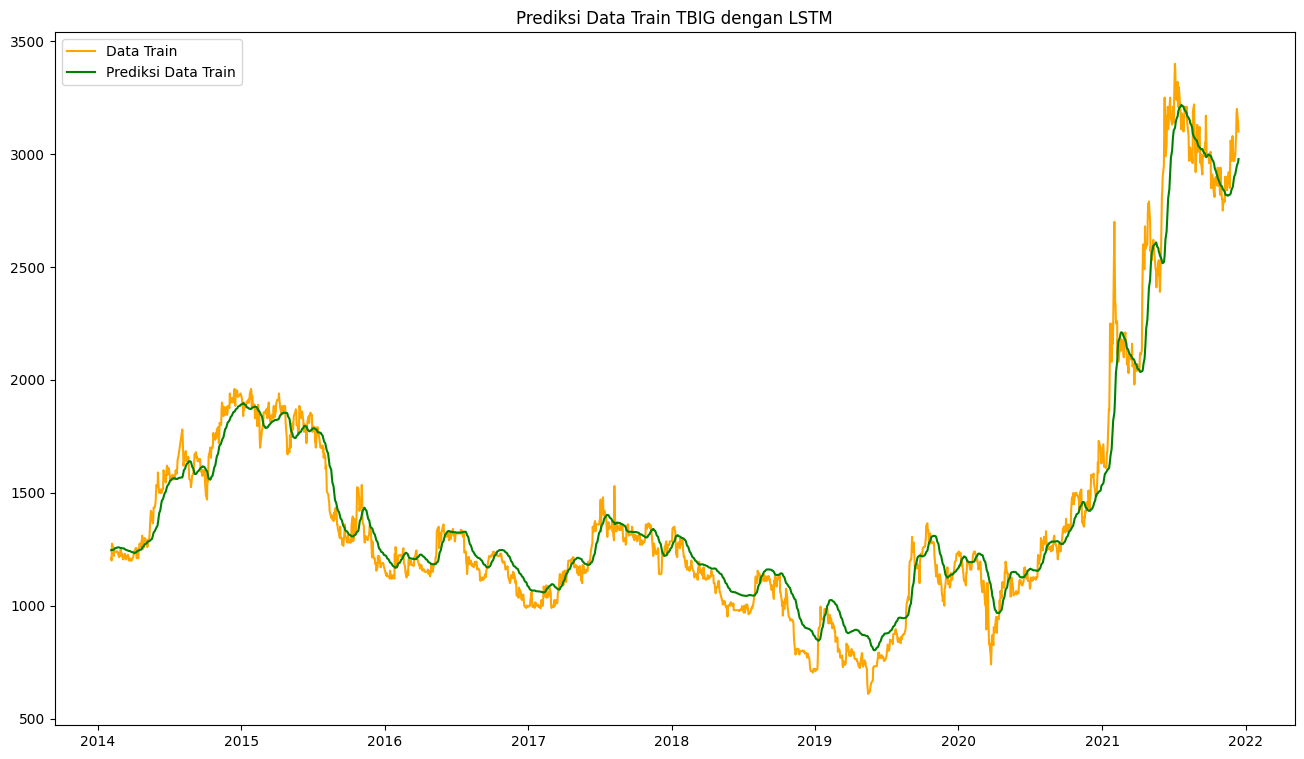

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_lstm.index, data_train_lstm, color="orange", label='Data Train')
plt.plot(data_train_lstm.index, y_train_pred_lstm, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TBIG dengan LSTM')
plt.legend(loc="upper left")
plot_train_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/train/tbig_train_lstm_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_lstm)
plt.show()

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_test_lstm = data_tbig[window_size_lstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_lstm.index, 'Data Test': data_test_lstm.values})
prediksi_test_lstm = pd.DataFrame({'Prediksi Data Test LSTM':  y_test_pred_lstm.flatten()})
tabel_prediksi_test_lstm = pd.concat([tabel_data_test, prediksi_test_lstm], axis = 1)
folder_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/test/lstm_6.csv'
tabel_prediksi_test_lstm.to_csv(folder_lstm, index=False, mode='a')
tabel_prediksi_test_lstm

,Date,Data Test,Prediksi Data Test LSTM
0,2022-01-14,2910.0,2949.260254
1,2022-01-17,2920.0,2936.923096
2,2022-01-18,2950.0,2923.258789
3,2022-01-19,2960.0,2913.597900
4,2022-01-20,3000.0,2906.484131
...,...,...,...
471,2023-12-21,2070.0,2047.405396
472,2023-12-22,2080.0,2049.068359
473,2023-12-27,2080.0,2050.030518
474,2023-12-28,2070.0,2051.214844


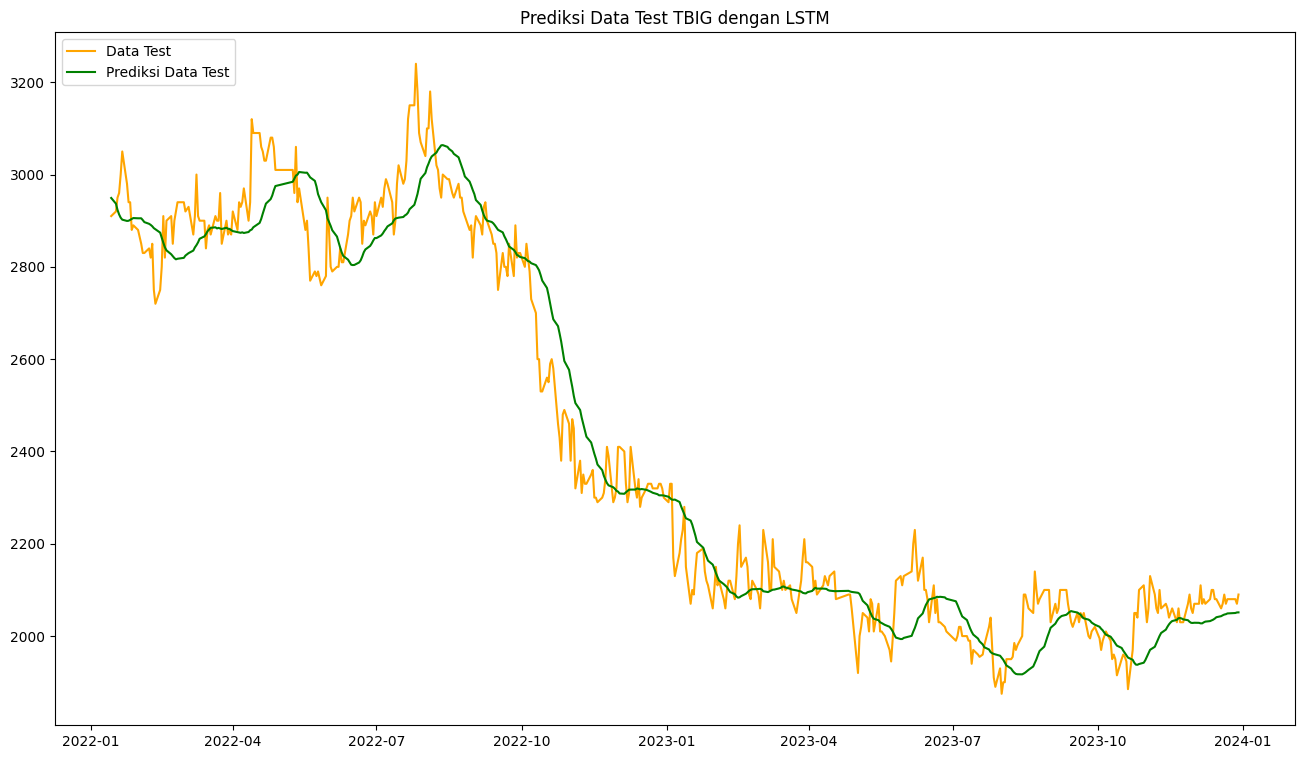

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_lstm.index, data_test_lstm, color="orange", label='Data Test')
plt.plot(data_test_lstm.index, y_test_pred_lstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TBIG dengan LSTM')
plt.legend(loc="upper left")
plot_test_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/test/tbig_test_lstm_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_lstm)
plt.show()

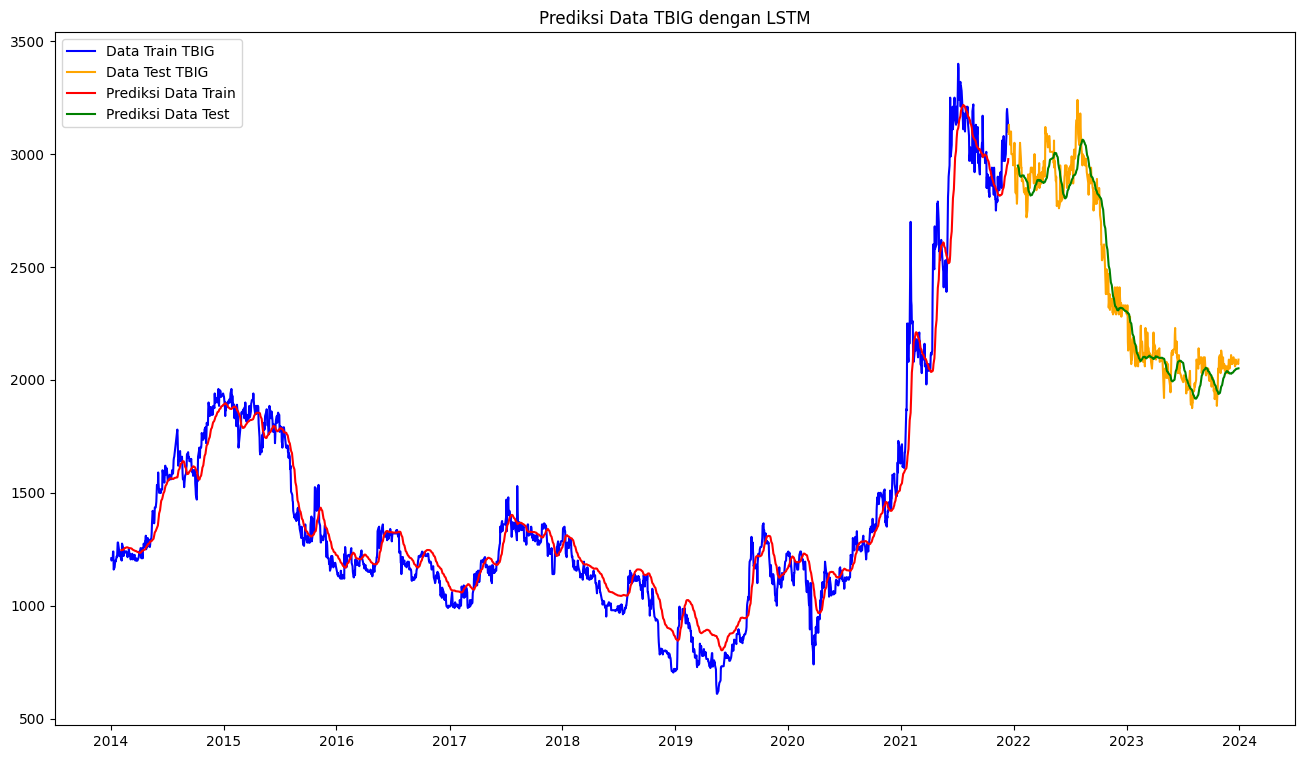

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="blue", label='Data Train TBIG')
plt.plot(df_test_tbig, color="orange", label='Data Test TBIG')
plt.plot(data_train_lstm.index, y_train_pred_lstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_lstm.index, y_test_pred_lstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TBIG dengan LSTM')
plt.legend(loc="upper left")
plot_lstm = '/content/drive/My Drive/skripsi/lstm/tbig/plot_lstm_6.png'
plt.savefig(plot_lstm)
plt.show()

---
## **PSO-LSTM**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tbig, df_test_tbig):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tbig_norm = scaler.fit_transform(df_train_tbig.values.reshape(-1,1))
  test_data_tbig_norm = scaler.transform(df_test_tbig.values.reshape(-1,1))
  return scaler, train_data_tbig_norm, test_data_tbig_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-LSTM**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_lstm(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params
  print('window_size', window_size, ', hidden_layers', hidden_layers,
        ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #LSTM model
  model = Sequential()
  model.add(LSTM(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tbig_norm, test_data_tbig_norm = normalize_data(df_train_tbig, df_test_tbig)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_tbig_norm, lb[0])
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_tbig_norm, lb[0])
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psolstm, best_value_psolstm = pso(objective_function_lstm, lb, ub, args=(X_train_psolstm, Y_train_psolstm, scaler, X_test_psolstm, Y_test_psolstm), swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psolstm)
print('RMSE:', best_value_psolstm)

window_size 12.655486748255045 , hidden_layers 47.202293171857065 , epochs 4.092316052342459 , batch_size 6.066859017675714
Epoch 1/4
329/329 [==============================] - 13s 22ms/step - loss: 0.0302 - val_loss: 0.0058
Epoch 2/4
329/329 [==============================] - 5s 14ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 3/4
329/329 [==============================] - 4s 11ms/step - loss: 0.0036 - val_loss: 6.2531e-04
Epoch 4/4
16/16 [==============================] - 0s 4ms/step
Validation RMSE:  0.031318858907952246 

window_size 19.375773215332536 , hidden_layers 40.144959887354744 , epochs 1.0136196097055477 , batch_size 21.8206791752753
16/16 [==============================] - 0s 4ms/step
Validation RMSE:  0.2206056946949626 

window_size 15.281969928275334 , hidden_layers 37.266328966640074 , epochs 5.470950026708116 , batch_size 18.810814238736853
Epoch 1/5
110/110 [==============================] - 5s 20ms/step - loss: 0.0549 - val_loss: 0.0874
Epoch 2/5
110/110 [=======

In [ ]:
optimal_window_size_psolstm = int(best_params_psolstm[0])
optimal_hidden_layer_psolstm = int(best_params_psolstm[1])
optimal_epochs_psolstm = int(best_params_psolstm[2])
optimal_batch_size_psolstm = int(best_params_psolstm[3])
print('Optimal window size: ', optimal_window_size_psolstm)
print('Optimal hidden layer: ', optimal_hidden_layer_psolstm)
print('Optimal epoch: ', optimal_epochs_psolstm)
print('Optimal batch size: ', optimal_batch_size_psolstm)

Optimal window size:  10
Optimal hidden layer:  49
Optimal epoch:  8
Optimal batch size:  2


In [ ]:
X_train_psolstm, Y_train_psolstm = prepare_dataset(train_data_tbig_norm, optimal_window_size_psolstm)
X_test_psolstm, Y_test_psolstm = prepare_dataset(test_data_tbig_norm, optimal_window_size_psolstm)
print("X_train: ", X_train_psolstm.shape)
print("Y_train: ", Y_train_psolstm.shape)
print("X_test: ", X_test_psolstm.shape)
print("Y_test", Y_test_psolstm.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
final_model_psolstm = Sequential()
final_model_psolstm.add(LSTM(units=optimal_hidden_layer_psolstm, input_shape=(X_train_psolstm.shape[1], 1), activation='tanh', dropout=0.2))
final_model_psolstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psolstm.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psolstm.fit(X_train_psolstm, Y_train_psolstm, epochs=optimal_epochs_psolstm, batch_size=optimal_batch_size_psolstm, validation_data=(X_test_psolstm, Y_test_psolstm))
y_train_pred_psolstm = final_model_psolstm.predict(X_train_psolstm)
y_test_pred_psolstm = final_model_psolstm.predict(X_test_psolstm)

Epoch 1/8
987/987 [==============================] - 10s 8ms/step - loss: 0.0160 - val_loss: 0.0017
Epoch 2/8
987/987 [==============================] - 8s 8ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 3/8
987/987 [==============================] - 8s 8ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 4/8
987/987 [==============================] - 6s 6ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 5/8
987/987 [==============================] - 6s 6ms/step - loss: 0.0039 - val_loss: 8.4908e-04
Epoch 6/8
987/987 [==============================] - 8s 8ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 7/8
987/987 [==============================] - 6s 6ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/8
16/16 [==============================] - 0s 3ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psolstm = scaler.inverse_transform(y_train_pred_psolstm.reshape(-1,1))
y_test_pred_psolstm = scaler.inverse_transform(y_test_pred_psolstm.reshape(-1,1))
Y_train_psolstm = scaler.inverse_transform(Y_train_psolstm.reshape(-1,1))
Y_test_psolstm = scaler.inverse_transform(Y_test_psolstm.reshape(-1,1))

####**Evaluasi Model**

In [ ]:

def mape(df_test_tbig, prediksi):
    return np.mean(np.abs((df_test_tbig - prediksi) / df_test_tbig)) * 100


#Evaluasi Train Data
r2_train_psolstm = r2_score(Y_train_psolstm, y_train_pred_psolstm)
rmse_train_psolstm = np.sqrt(mse(Y_train_psolstm, y_train_pred_psolstm))
mae_train_psolstm = mae(Y_train_psolstm, y_train_pred_psolstm)
mape_train_psolstm = mape(Y_train_psolstm, y_train_pred_psolstm)
print('R2 pada Train Data :', r2_train_psolstm)
print('RMSE pada Train Data :', rmse_train_psolstm)
print('MAE pada Train Data :', mae_train_psolstm)
print('MAPE pada Train Data :', mape_train_psolstm)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psolstm = r2_score(Y_test_psolstm, y_test_pred_psolstm)
rmse_test_psolstm = np.sqrt(mse(Y_test_psolstm, y_test_pred_psolstm))
mae_test_psolstm = mae(Y_test_psolstm, y_test_pred_psolstm)
mape_test_psolstm = mape(Y_test_psolstm, y_test_pred_psolstm)
print('R2 pada Test Data :', r2_test_psolstm)
print('RMSE pada Test Data :', rmse_test_psolstm)
print('MAE pada Test Data :', mae_test_psolstm)
print('MAPE pada Test Data :', mape_test_psolstm)
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9769427474262548
RMSE pada Train Data : 85.50336086599647
MAE pada Train Data : 53.74426068554292
MAPE pada Train Data : 3.5840847678957526
------------------------------------------
R2 pada Test Data : 0.9249259789763473
RMSE pada Test Data : 111.0353847947336
MAE pada Test Data : 87.0298288604359
MAPE pada Test Data : 3.3675423930833968
Training time: 1949.705997467041


In [ ]:
params_psolstm = {
    'Window Size': optimal_window_size_psolstm,
    'Hidden Layers': optimal_hidden_layer_psolstm,

    'Epochs': optimal_epochs_psolstm,
    'Batch Size': optimal_batch_size_psolstm,
    'R2 Train': r2_train_psolstm,
    'RMSE Train': rmse_train_psolstm,
    'MAE Train': mae_train_psolstm,
    'MAPE Train': mape_train_psolstm,
    'R2 Test': r2_test_psolstm,
    'RMSE Test': rmse_test_psolstm,
    'MAE Test': mae_test_psolstm,
    'MAPE Test': mape_test_psolstm
}

results_psolstm = pd.DataFrame([params_psolstm])
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/psolstm_results.csv'
results_psolstm.to_csv(folder_psolstm, index=False, mode='a', header=False)
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tbig/psolstm_results.csv')
results_psolstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,11,25,6,1,0.982769,73.932202,50.268917,3.670711,0.966628,73.969466,57.002119,2.304108
1,16,27,8,13,0.978813,82.074850,54.520363,4.003156,0.965656,74.769006,56.930641,2.321866
2,10,49,8,2,0.976943,85.503361,53.744261,3.584085,0.924926,111.035385,87.029829,3.367542


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_train_psolstm = data_tbig[optimal_window_size_psolstm + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psolstm.index,  'Data Train': data_train_psolstm.values})
prediksi_train_psolstm = pd.DataFrame({'Prediksi Data Train PSO-LSTM':  y_train_pred_psolstm.flatten()})
tabel_prediksi_train_psolstm = pd.concat([tabel_data_train, prediksi_train_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/train/psolstm_3.csv'
tabel_prediksi_train_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_train_psolstm

,Date,Data Train,Prediksi Data Train PSO-LSTM
0,2014-01-20,1220.0,1201.286011
1,2014-01-21,1215.0,1199.799683
2,2014-01-22,1245.0,1200.790405
3,2014-01-23,1280.0,1201.261963
4,2014-01-24,1280.0,1204.382446
...,...,...,...
1969,2021-12-08,3080.0,2849.282471
1970,2021-12-09,3180.0,2852.394043
1971,2021-12-10,3200.0,2854.427490
1972,2021-12-13,3140.0,2866.743652


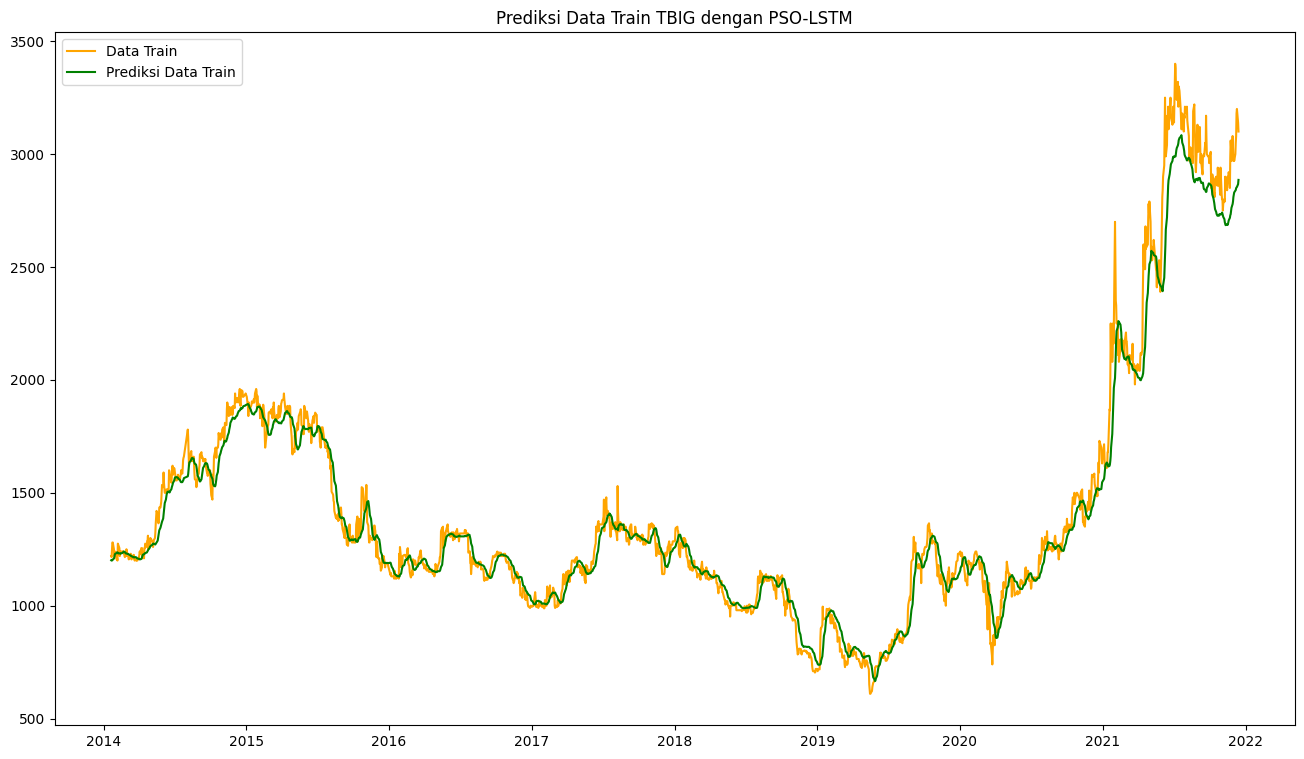

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_psolstm.index, data_train_psolstm, color="orange", label='Data Train')
plt.plot(data_train_psolstm.index, y_train_pred_psolstm, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TBIG dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_train_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/train/tbig_train_psolstm_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_psolstm)
plt.show()

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_test_psolstm = data_tbig[optimal_window_size_psolstm + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psolstm.index, 'Data Test': data_test_psolstm.values})
prediksi_test_psolstm = pd.DataFrame({'Prediksi Data Test PSO-LSTM':  y_test_pred_psolstm.flatten()})
tabel_prediksi_test_psolstm = pd.concat([tabel_data_test, prediksi_test_psolstm], axis = 1)
folder_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/test/psolstm_3.csv'
tabel_prediksi_test_psolstm.to_csv(folder_psolstm, index=False, mode='a')
tabel_prediksi_test_psolstm


,Date,Data Test,Prediksi Data Test PSO-LSTM
0,2021-12-30,2950.0,2895.1116
1,2022-01-03,3050.0,2885.0798
2,2022-01-04,3010.0,2870.4714
3,2022-01-05,2930.0,2865.5051
4,2022-01-06,2830.0,2859.0380
...,...,...,...
481,2023-12-21,2070.0,2030.4418
482,2023-12-22,2080.0,2031.4565
483,2023-12-27,2080.0,2030.4884
484,2023-12-28,2070.0,2030.8213


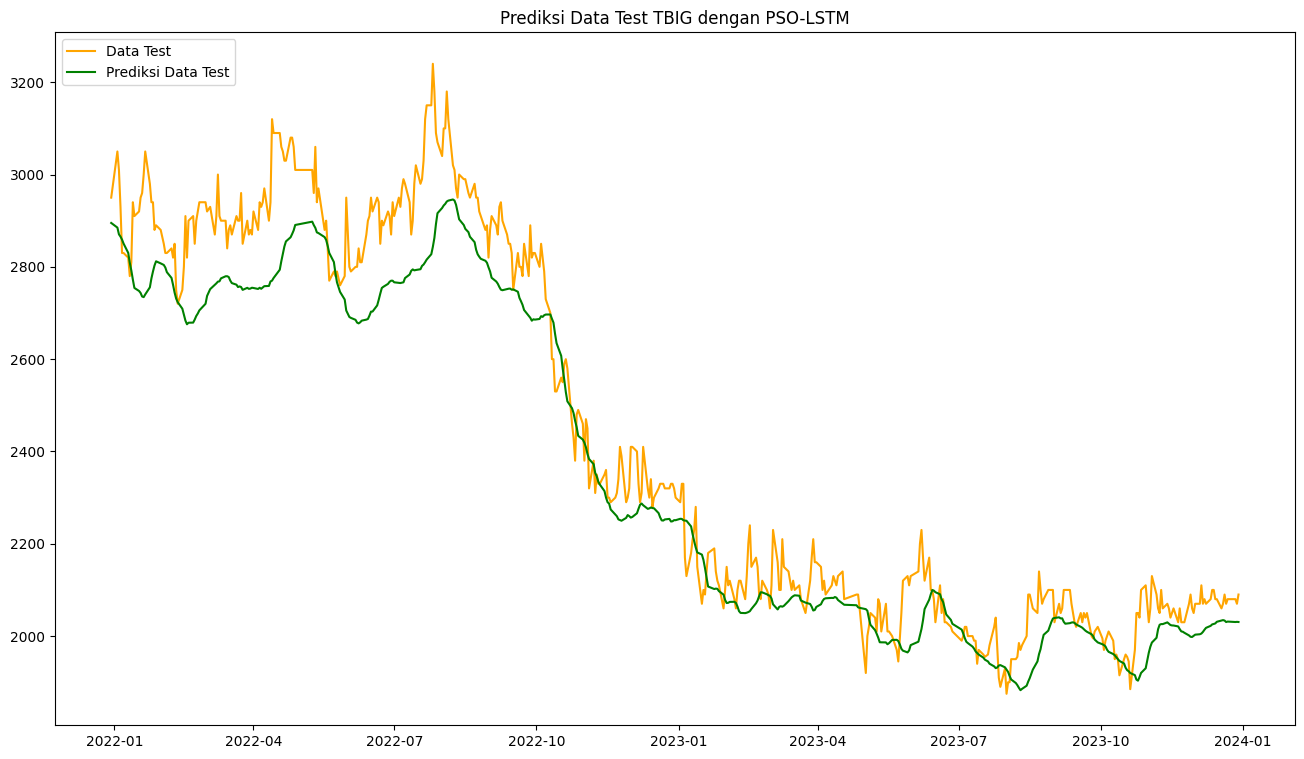

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_psolstm.index, data_test_psolstm, color="orange", label='Data Test')
plt.plot(data_test_psolstm.index, y_test_pred_psolstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TBIG dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_test_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/test/tbig_test_psolstm_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_psolstm)
plt.show()

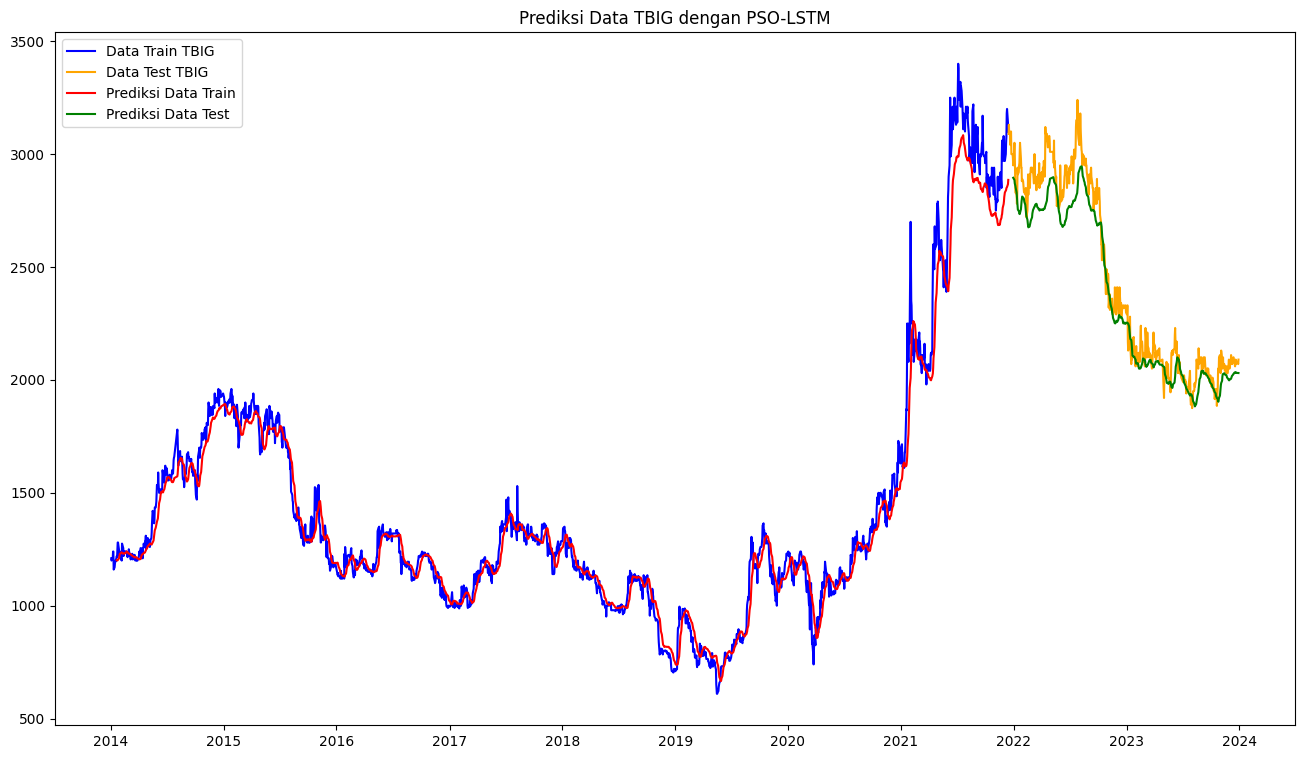

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="blue", label='Data Train TBIG')
plt.plot(df_test_tbig, color="orange", label='Data Test TBIG')
plt.plot(data_train_psolstm.index, y_train_pred_psolstm, color="red", label='Prediksi Data Train')
plt.plot(data_test_psolstm.index, y_test_pred_psolstm, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TBIG dengan PSO-LSTM')
plt.legend(loc="upper left")
plot_psolstm = '/content/drive/My Drive/skripsi/pso-lstm/tbig/plot_psolstm_3.png'
plt.savefig(plot_psolstm)
plt.show()

---
## **GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tbig, df_test_tbig):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tbig_norm = scaler.fit_transform(df_train_tbig.values.reshape(-1,1))
  test_data_tbig_norm = scaler.transform(df_test_tbig.values.reshape(-1,1))
  return scaler, train_data_tbig_norm, test_data_tbig_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tbig_norm, test_data_tbig_norm = normalize_data(df_train_tbig, df_test_tbig)

####**Hyperparameter tuning**

In [ ]:
params = (20, 50, 10, 32)
window_size_gru = int(params[0])
hidden_layer_gru = int( params[1])
epochs_gru = int( params[2])
batch_size_gru = int( params[3])
print('Window size: ', window_size_gru)
print('Hidden layer: ', hidden_layer_gru)
print('Epochs: ', epochs_gru)
print('Batch Size: ', batch_size_gru)

Window size:  20
Hidden layer:  50
Epochs:  10
Batch Size:  32


In [ ]:
X_train_gru, Y_train_gru = prepare_dataset(train_data_tbig_norm, window_size_gru)
X_test_gru, Y_test_gru = prepare_dataset(test_data_tbig_norm, window_size_gru)
print("X_train: ", X_train_gru.shape)
print("Y_train: ", Y_train_gru.shape)
print("X_test: ", X_test_gru.shape)
print("Y_test", Y_test_gru.shape)

X_train:  (1964, 20, 1)
Y_train:  (1964, 1)
X_test:  (476, 20, 1)
Y_test (476, 1)


In [ ]:
start_time = time.time()
#GRU model
final_model_gru = Sequential()
final_model_gru.add(GRU(units=int(hidden_layer_gru), input_shape=(X_train_gru.shape[1], 1),
                 activation='tanh', dropout=0.2))
final_model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

#Train model
final_model_gru.fit(X_train_gru, Y_train_gru, epochs=int(epochs_gru), batch_size=int(batch_size_gru),
            validation_data=(X_test_gru, Y_test_gru), callbacks=[early_stopping])
end_time = time.time()

#Predictions
y_train_pred_gru = final_model_gru.predict(X_train_gru)
y_test_pred_gru = final_model_gru.predict(X_test_gru)

Epoch 1/10
62/62 [==============================] - 4s 20ms/step - loss: 0.1062 - val_loss: 0.2815
Epoch 2/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0457 - val_loss: 0.1215
Epoch 3/10
62/62 [==============================] - 1s 12ms/step - loss: 0.0197 - val_loss: 0.0475
Epoch 4/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0133 - val_loss: 0.0274
Epoch 5/10
62/62 [==============================] - 1s 18ms/step - loss: 0.0102 - val_loss: 0.0162
Epoch 6/10
62/62 [==============================] - 1s 20ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 7/10
62/62 [==============================] - 1s 20ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 8/10
62/62 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 9/10
62/62 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 10/10
15/15 [==============================] - 0s 4ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.reshape(-1,1))
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru.reshape(-1,1))
Y_train_gru = scaler.inverse_transform(Y_train_gru.reshape(-1,1))
Y_test_gru = scaler.inverse_transform(Y_test_gru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_tbig, prediksi):
    return np.mean(np.abs((df_test_tbig - prediksi) / df_test_tbig)) * 100

#Evaluasi Train Data
r2_train_gru = r2_score(Y_train_gru, y_train_pred_gru)
rmse_train_gru = np.sqrt(mse(Y_train_gru, y_train_pred_gru))
mae_train_gru = mae(Y_train_gru, y_train_pred_gru)
mape_train_gru = mape(Y_train_gru, y_train_pred_gru)
print('R2 pada Train Data :', r2_train_gru)
print('RMSE pada Train Data :', rmse_train_gru)
print('MAE pada Train Data :', mae_train_gru)
print('MAPE pada Train Data :', mape_train_gru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_gru = r2_score(Y_test_gru, y_test_pred_gru)
rmse_test_gru = np.sqrt(mse(Y_test_gru, y_test_pred_gru))
mae_test_gru = mae(Y_test_gru, y_test_pred_gru)
mape_test_gru = mape(Y_test_gru, y_test_pred_gru)
print('R2 pada Test Data :', r2_test_gru)
print('RMSE pada Test Data :', rmse_test_gru)
print('MAE pada Test Data :', mae_test_gru)
print('MAPE pada Test Data :', mape_test_gru)
print("Training time: "  + str(end_time - start_time))

R2 pada Train Data : 0.9765639384715086
RMSE pada Train Data : 86.3995530344858
MAE pada Train Data : 60.15167873405876
MAPE pada Train Data : 4.612343159287712
------------------------------------------
R2 pada Test Data : 0.9519243733875061
RMSE pada Test Data : 88.50196315267273
MAE pada Test Data : 72.12445170939463
MAPE pada Test Data : 2.9899474473361205
Training time: 13.104427099227905


In [ ]:
params_gru = {
    'Window Size': window_size_gru,
    'Hidden Layers': hidden_layer_gru,
    'Epochs': epochs_gru,
    'Batch Size': batch_size_gru,
    'R2 Train': r2_train_gru,
    'RMSE Train': rmse_train_gru,
    'MAE Train': mae_train_gru,
    'MAPE Train': mape_train_gru,
    'R2 Test': r2_test_gru,
    'RMSE Test': rmse_test_gru,
    'MAE Test': mae_test_gru,
    'MAPE Test': mape_test_gru
}

results_gru = pd.DataFrame([params_gru])
folder_gru = '/content/drive/My Drive/skripsi/gru/tbig/gru_results.csv'
results_gru.to_csv(folder_gru, index=False, mode='a', header=False)
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tbig/gru_results.csv')
results_gru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.969493,98.351403,71.908346,5.368524,0.866934,147.825935,128.755625,5.050897
1,10,50,10,32,0.983675,71.944841,53.834525,4.206077,0.966991,73.626700,55.272305,2.164895
2,15,25,10,32,0.928323,150.923939,116.630015,8.942542,0.676721,229.390620,205.132753,8.053506
3,15,50,10,32,0.981785,76.082168,54.153387,4.182694,0.958772,81.918840,65.207576,2.624319
4,20,25,10,32,0.967295,102.065306,75.752025,5.721570,0.868672,146.274661,123.625125,4.802378
5,20,50,10,32,0.976564,86.399553,60.151679,4.612343,0.951924,88.501963,72.124452,2.989947


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_train_gru = data_tbig[window_size_gru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_gru.index,  'Data Train': data_train_gru.values})
prediksi_train_gru = pd.DataFrame({'Prediksi Data Train gru':  y_train_pred_gru.flatten()})
tabel_prediksi_train_gru = pd.concat([tabel_data_train, prediksi_train_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/tbig/train/gru_6.csv'
tabel_prediksi_train_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_train_gru

,Date,Data Train,Prediksi Data Train gru
0,2014-02-04,1210.0,1246.306763
1,2014-02-05,1200.0,1244.710815
2,2014-02-06,1275.0,1241.318970
3,2014-02-07,1270.0,1237.305908
4,2014-02-10,1255.0,1236.746460
...,...,...,...
1959,2021-12-08,3080.0,2922.101562
1960,2021-12-09,3180.0,2926.703857
1961,2021-12-10,3200.0,2935.543213
1962,2021-12-13,3140.0,2951.377197


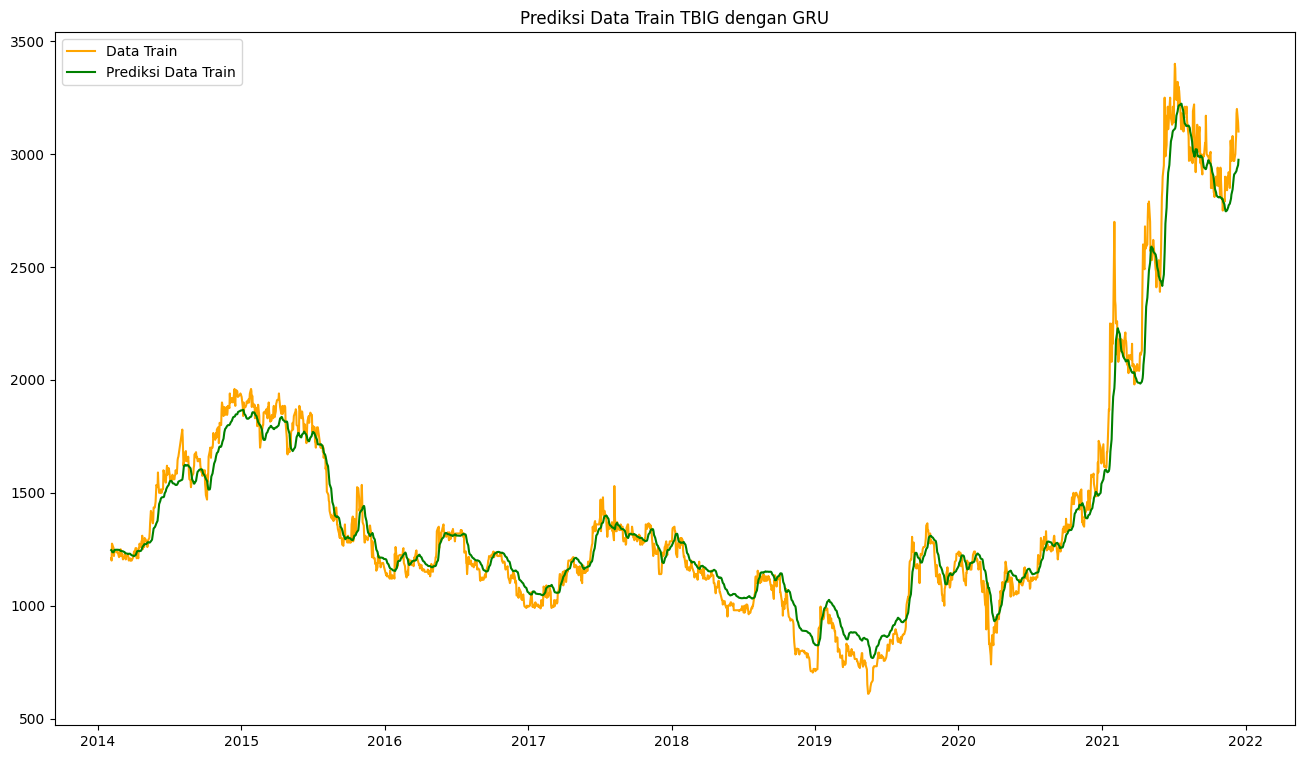

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_gru.index, data_train_gru, color="orange", label='Data Train')
plt.plot(data_train_gru.index, y_train_pred_gru, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TBIG dengan GRU')
plt.legend(loc="upper left")
plot_train_gru = '/content/drive/My Drive/skripsi/gru/tbig/train/tbig_train_gru_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_gru)
plt.show()

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_test_gru = data_tbig[window_size_gru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_gru.index, 'Data Test': data_test_gru.values})
prediksi_test_gru = pd.DataFrame({'Prediksi Data Test GRU':  y_test_pred_gru.flatten()})
tabel_prediksi_test_gru = pd.concat([tabel_data_test, prediksi_test_gru], axis = 1)
folder_gru = '/content/drive/My Drive/skripsi/gru/tbig/test/gru_6.csv'
tabel_prediksi_test_gru.to_csv(folder_gru, index=False, mode='a')
tabel_prediksi_test_gru

,Date,Data Test,Prediksi Data Test GRU
0,2022-01-14,2910.0,2842.911133
1,2022-01-17,2920.0,2827.095459
2,2022-01-18,2950.0,2822.406738
3,2022-01-19,2960.0,2822.179688
4,2022-01-20,3000.0,2825.720703
...,...,...,...
471,2023-12-21,2070.0,2009.185669
472,2023-12-22,2080.0,2008.461792
473,2023-12-27,2080.0,2008.340942
474,2023-12-28,2070.0,2007.932617


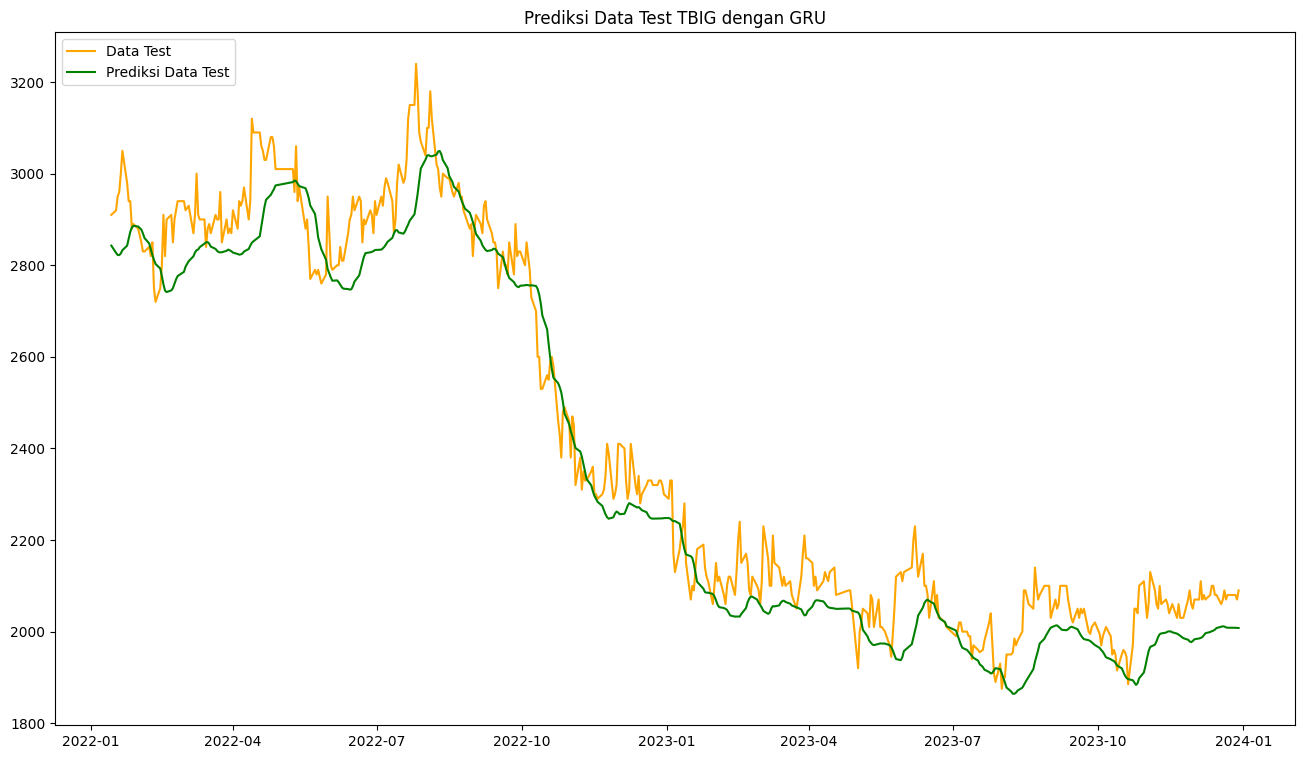

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_gru.index, data_test_gru, color="orange", label='Data Test')
plt.plot(data_test_gru.index, y_test_pred_gru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TBIG dengan GRU')
plt.legend(loc="upper left")
plot_test_gru = '/content/drive/My Drive/skripsi/gru/tbig/test/tbig_test_gru_6.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_gru)
plt.show()

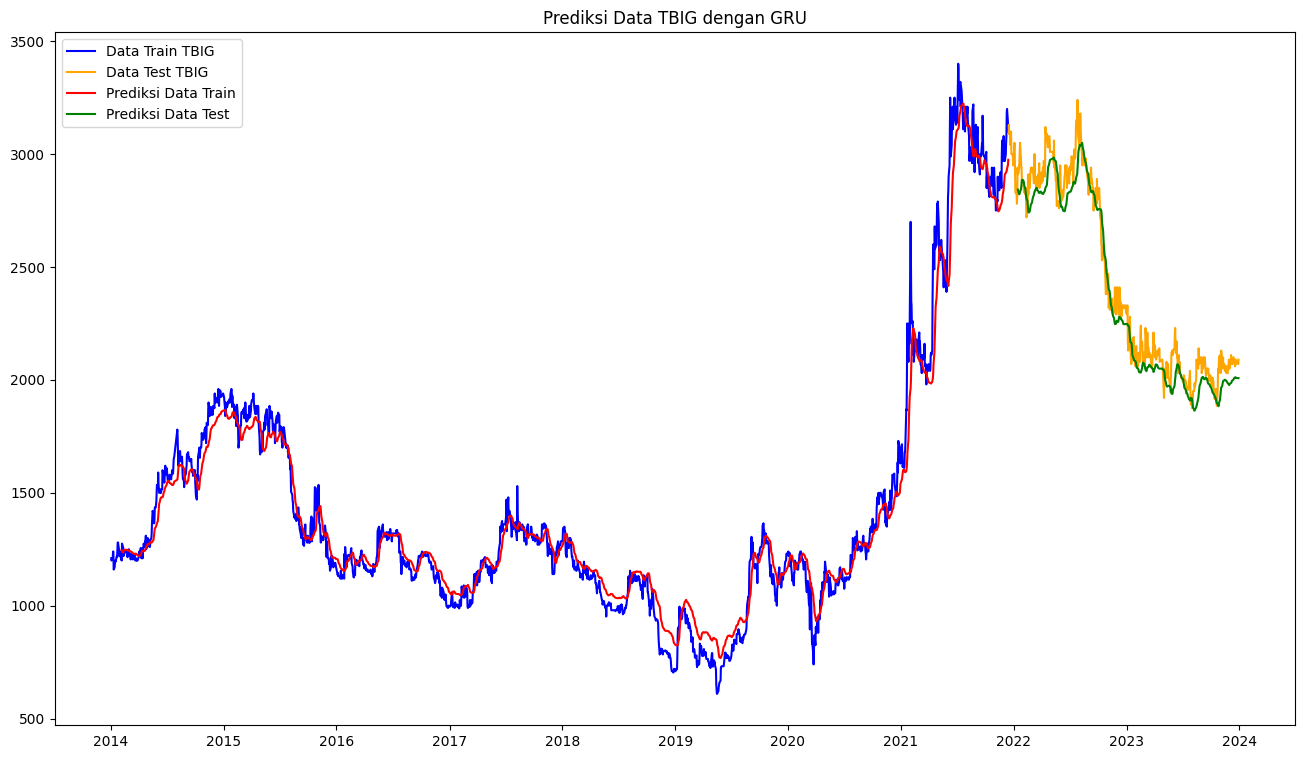

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="blue", label='Data Train TBIG')
plt.plot(df_test_tbig, color="orange", label='Data Test TBIG')
plt.plot(data_train_gru.index, y_train_pred_gru, color="red", label='Prediksi Data Train')
plt.plot(data_test_gru.index, y_test_pred_gru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TBIG dengan GRU')
plt.legend(loc="upper left")
plot_gru = '/content/drive/My Drive/skripsi/gru/tbig/plot_gru_6.png'
plt.savefig(plot_gru)
plt.show()

---
## **PSO-GRU**
---

### **Function**

####**Normalisasi Data**

In [ ]:
def normalize_data(df_train_tbig, df_test_tbig):
  scaler = MinMaxScaler(feature_range = (0,1))
  train_data_tbig_norm = scaler.fit_transform(df_train_tbig.values.reshape(-1,1))
  test_data_tbig_norm = scaler.transform(df_test_tbig.values.reshape(-1,1))
  return scaler, train_data_tbig_norm, test_data_tbig_norm

####**Window Size**

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        Y.append(data[i + window_size, 0])
    X = np.array(X).reshape(len(X), window_size, 1)
    Y = np.array(Y).reshape(len(Y), 1)
    return X, Y

####**Objective function for PSO-GRU**

In [ ]:
# Objective function for PSO (minimize RMSE)
def objective_function_gru(params, X_train, Y_train, scaler, X_test, Y_test):
  window_size, hidden_layers, epochs, batch_size = params

  print('window_size', window_size, ', hidden_layers', hidden_layers,
          ', epochs', epochs, ', batch_size', batch_size)

  if window_size == 0 or batch_size == 0:
        return 10,

  #GRU model
  model = Sequential()
  model.add(GRU(units=int(hidden_layers), input_shape=(X_train.shape[1], 1),
                 activation='tanh', dropout=0.2))
  model.add(Dense(units=1))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  #Early Stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)

  #Train model
  model.fit(X_train, Y_train, epochs=int(epochs), batch_size=int(batch_size),
            validation_data=(X_test, Y_test), callbacks=[early_stopping])

  #Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  #RMSE
  rmse = np.sqrt(mse(Y_train, y_train_pred))
  print('Validation RMSE: ', rmse,'\n')
  return rmse

### **Build Model**

####**Normalisasi Data**

In [ ]:
scaler, train_data_tbig_norm, test_data_tbig_norm = normalize_data(df_train_tbig, df_test_tbig)

####**PSO hyperparameter tuning**

In [ ]:
lb = [10, 25, 1, 1] # Lower bounds for the parameters
ub = [20, 50, 10, 32] #Upper bounds for the parameters

In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_tbig_norm, lb[0])
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_tbig_norm, lb[0])
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1974, 10, 1)
Y_train:  (1974, 1)
X_test:  (486, 10, 1)
Y_test (486, 1)


In [ ]:
#Run PSO to optimize hyperparameters
start_time = time.time()
best_params_psogru, best_value_psogru = pso(objective_function_gru, lb, ub, args=(X_train_psogru, Y_train_psogru, scaler, X_test_psogru, Y_test_psogru), swarmsize=5, maxiter=5)
end_time = time.time()
# Print the best parameters found by PSO
print('Best Parameters:', best_params_psogru)
print('RMSE:', best_value_psogru)

window_size 18.306341991759716 , hidden_layers 37.94233813235319 , epochs 6.006395307594172 , batch_size 23.560773570247694
Epoch 1/6
86/86 [==============================] - 3s 13ms/step - loss: 0.1154 - val_loss: 0.2910
Epoch 2/6
86/86 [==============================] - 1s 7ms/step - loss: 0.0416 - val_loss: 0.1009
Epoch 3/6
86/86 [==============================] - 1s 7ms/step - loss: 0.0181 - val_loss: 0.0405
Epoch 4/6
86/86 [==============================] - 1s 11ms/step - loss: 0.0136 - val_loss: 0.0252
Epoch 5/6
86/86 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0133
Epoch 6/6
16/16 [==============================] - 0s 5ms/step
Validation RMSE:  0.06250858565860751 

window_size 18.720209553686395 , hidden_layers 38.29104830180091 , epochs 1.886876239467714 , batch_size 31.809893939005285
16/16 [==============================] - 0s 2ms/step
Validation RMSE:  0.25147913306314684 

window_size 16.320292326172577 , hidden_layers 48.042996617584464 , 

In [ ]:
optimal_window_size_psogru = int(best_params_psogru[0])
optimal_hidden_layer_psogru = int(best_params_psogru[1])
optimal_epochs_psogru = int(best_params_psogru[2])
optimal_batch_size_psogru = int(best_params_psogru[3])
print('Optimal window size: ', optimal_window_size_psogru)
print('Optimal hidden layer: ', optimal_hidden_layer_psogru)
print('Optimal epoch: ', optimal_epochs_psogru)
print('Optimal batch size: ', optimal_batch_size_psogru)

Optimal window size:  19
Optimal hidden layer:  50
Optimal epoch:  6
Optimal batch size:  13


In [ ]:
X_train_psogru, Y_train_psogru = prepare_dataset(train_data_tbig_norm, optimal_window_size_psogru)
X_test_psogru, Y_test_psogru = prepare_dataset(test_data_tbig_norm, optimal_window_size_psogru)
print("X_train: ", X_train_psogru.shape)
print("Y_train: ", Y_train_psogru.shape)
print("X_test: ", X_test_psogru.shape)
print("Y_test", Y_test_psogru.shape)

X_train:  (1965, 19, 1)
Y_train:  (1965, 1)
X_test:  (477, 19, 1)
Y_test (477, 1)


In [ ]:
final_model_psogru = Sequential()
final_model_psogru.add(GRU(units=optimal_hidden_layer_psogru, input_shape=(X_train_psogru.shape[1], 1), activation='tanh', dropout=0.2))
final_model_psogru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.0001)
final_model_psogru.compile(optimizer=optimizer, loss='mean_squared_error')
final_model_psogru.fit(X_train_psogru, Y_train_psogru, epochs=optimal_epochs_psogru, batch_size=optimal_batch_size_psogru, validation_data=(X_test_psogru, Y_test_psogru))
y_train_pred_psogru = final_model_psogru.predict(X_train_psogru)
y_test_pred_psogru = final_model_psogru.predict(X_test_psogru)

Epoch 1/6
152/152 [==============================] - 4s 13ms/step - loss: 0.0402 - val_loss: 0.0310
Epoch 2/6
152/152 [==============================] - 2s 10ms/step - loss: 0.0086 - val_loss: 0.0095
Epoch 3/6
152/152 [==============================] - 2s 10ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 4/6
152/152 [==============================] - 2s 13ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 5/6
152/152 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 6/6
15/15 [==============================] - 0s 5ms/step


####**Denormalisasi Data**

In [ ]:
# Transform back to original form
y_train_pred_psogru = scaler.inverse_transform(y_train_pred_psogru.reshape(-1,1))
y_test_pred_psogru = scaler.inverse_transform(y_test_pred_psogru.reshape(-1,1))
Y_train_psogru = scaler.inverse_transform(Y_train_psogru.reshape(-1,1))
Y_test_psogru = scaler.inverse_transform(Y_test_psogru.reshape(-1,1))

####**Evaluasi Model**

In [ ]:
def mape(df_test_tbig, prediksi):
    return np.mean(np.abs((df_test_tbig - prediksi) / df_test_tbig)) * 100

#Evaluasi Train Data
r2_train_psogru = r2_score(Y_train_psogru, y_train_pred_psogru)
rmse_train_psogru = np.sqrt(mse(Y_train_psogru, y_train_pred_psogru))
mae_train_psogru = mae(Y_train_psogru, y_train_pred_psogru)
mape_train_psogru = mape(Y_train_psogru, y_train_pred_psogru)
print('R2 pada Train data :', r2_train_psogru)
print('RMSE pada Train data :', rmse_train_psogru)
print('MAE pada Train data :', mae_train_psogru)
print('MAPE pada Train data :', mape_train_psogru)
print("------------------------------------------")

#Evaluasi Test Data
r2_test_psogru = r2_score(Y_test_psogru, y_test_pred_psogru)
rmse_test_psogru = np.sqrt(mse(Y_test_psogru, y_test_pred_psogru))
mae_test_psogru = mae(Y_test_psogru, y_test_pred_psogru)
mape_test_psogru = mape(Y_test_psogru, y_test_pred_psogru)
print('R2 pada Test data :', r2_test_psogru)
print('RMSE pada Test data :', rmse_test_psogru)
print('MAE pada Test data :', mae_test_psogru)
print('MAPE pada Test data :', mape_test_psogru)
print("Training time: "  + str(end_time - start_time))

R2 pada Train data : 0.9751374633395115
RMSE pada Train data : 88.96972602762789
MAE pada Train data : 58.967570390774085
MAPE pada Train data : 4.076161785803154
------------------------------------------
R2 pada Test data : 0.91814288922026
RMSE pada Test data : 115.47062048870683
MAE pada Test data : 99.52934319518141
MAPE pada Test data : 4.062214784870007
Training time: 424.10167694091797


In [ ]:
params_psogru = {
    'Window Size': optimal_window_size_psogru,
    'Hidden Layers': optimal_hidden_layer_psogru,
    'Epochs': optimal_epochs_psogru,
    'Batch Size': optimal_batch_size_psogru,
    'R2 Train': r2_train_psogru,
    'RMSE Train': rmse_train_psogru,
    'MAE Train': mae_train_psogru,
    'MAPE Train': mape_train_psogru,
    'R2 Test': r2_test_psogru,
    'RMSE Test': rmse_test_psogru,
    'MAE Test': mae_test_psogru,
    'MAPE Test': mape_test_psogru
}

results_psogru = pd.DataFrame([params_psogru])
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/psogru_results.csv'
results_psogru.to_csv(folder_psogru, index=False, mode='a', header=False)
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tbig/psogru_results.csv')
results_psogru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,18,28,10,7,0.981054,77.647661,52.317602,3.919317,0.967341,72.918520,54.298202,2.182063
1,15,30,4,5,0.978158,83.313175,54.091271,3.602935,0.916815,116.361274,100.281562,4.041372
2,19,50,6,13,0.975137,88.969726,58.967570,4.076162,0.918143,115.470620,99.529343,4.062215


###**Comparison Real vs Prediction**

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_train_psogru = data_tbig[optimal_window_size_psogru + 1:int(split_data)]
tabel_data_train = pd.DataFrame({'Date': data_train_psogru.index,  'Data Train': data_train_psogru.values})
prediksi_train_psogru = pd.DataFrame({'Prediksi Data Train PSO-GRU':  y_train_pred_psogru.flatten()})
tabel_prediksi_train_psogru = pd.concat([tabel_data_train, prediksi_train_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/train/psogru_3.csv'
tabel_prediksi_train_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_train_psogru

,Date,Data Train,Prediksi Data Train PSO-GRU
0,2014-02-03,1205.0,1225.515625
1,2014-02-04,1210.0,1225.411743
2,2014-02-05,1200.0,1222.446655
3,2014-02-06,1275.0,1218.776855
4,2014-02-07,1270.0,1214.449707
...,...,...,...
1960,2021-12-08,3080.0,2858.333008
1961,2021-12-09,3180.0,2864.226562
1962,2021-12-10,3200.0,2874.943604
1963,2021-12-13,3140.0,2894.112549


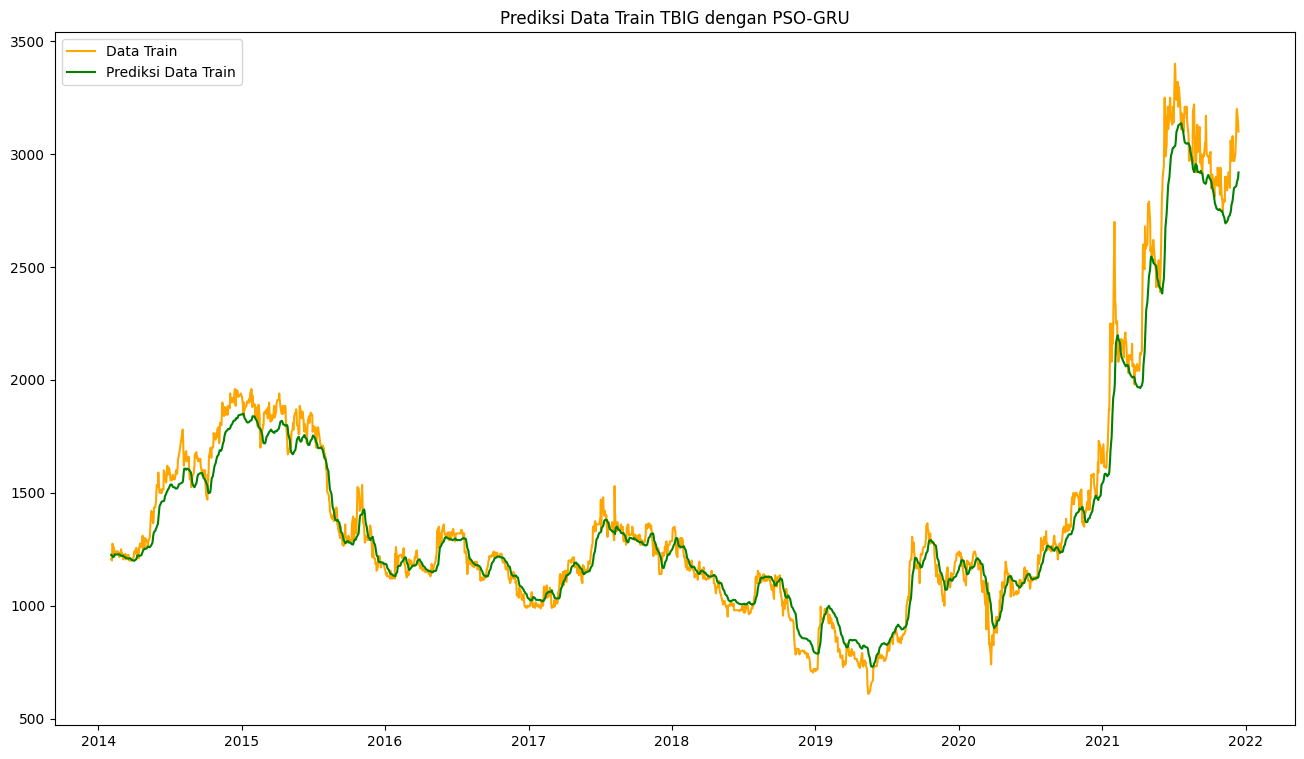

In [ ]:
#plot the predictions for train set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_train_psogru.index, data_train_psogru, color="orange", label='Data Train')
plt.plot(data_train_psogru.index, y_train_pred_psogru, color="green", label='Prediksi Data Train')
plt.title('Prediksi Data Train TBIG dengan PSO-GRU')
plt.legend(loc="upper left")
plot_train_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/train/tbig_train_psogru_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_train_psogru)
plt.show()

In [ ]:
split_data = data_tbig.shape[0] * 0.8
data_test_psogru = data_tbig[optimal_window_size_psogru + 1 + int(split_data):]
tabel_data_test = pd.DataFrame({'Date': data_test_psogru.index, 'Data Test': data_test_psogru.values})
prediksi_test_psogru = pd.DataFrame({'Prediksi Data Test GRU':  y_test_pred_psogru.flatten()})
tabel_prediksi_test_psogru = pd.concat([tabel_data_test, prediksi_test_psogru], axis = 1)
folder_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/test/psogru_3.csv'
tabel_prediksi_test_psogru.to_csv(folder_psogru, index=False, mode='a')
tabel_prediksi_test_psogru

,Date,Data Test,Prediksi Data Test GRU
0,2022-01-13,2940.0,2796.633545
1,2022-01-14,2910.0,2774.853516
2,2022-01-17,2920.0,2766.613770
3,2022-01-18,2950.0,2765.686279
4,2022-01-19,2960.0,2767.520752
...,...,...,...
472,2023-12-21,2070.0,1987.919556
473,2023-12-22,2080.0,1988.142456
474,2023-12-27,2080.0,1987.790771
475,2023-12-28,2070.0,1987.579590


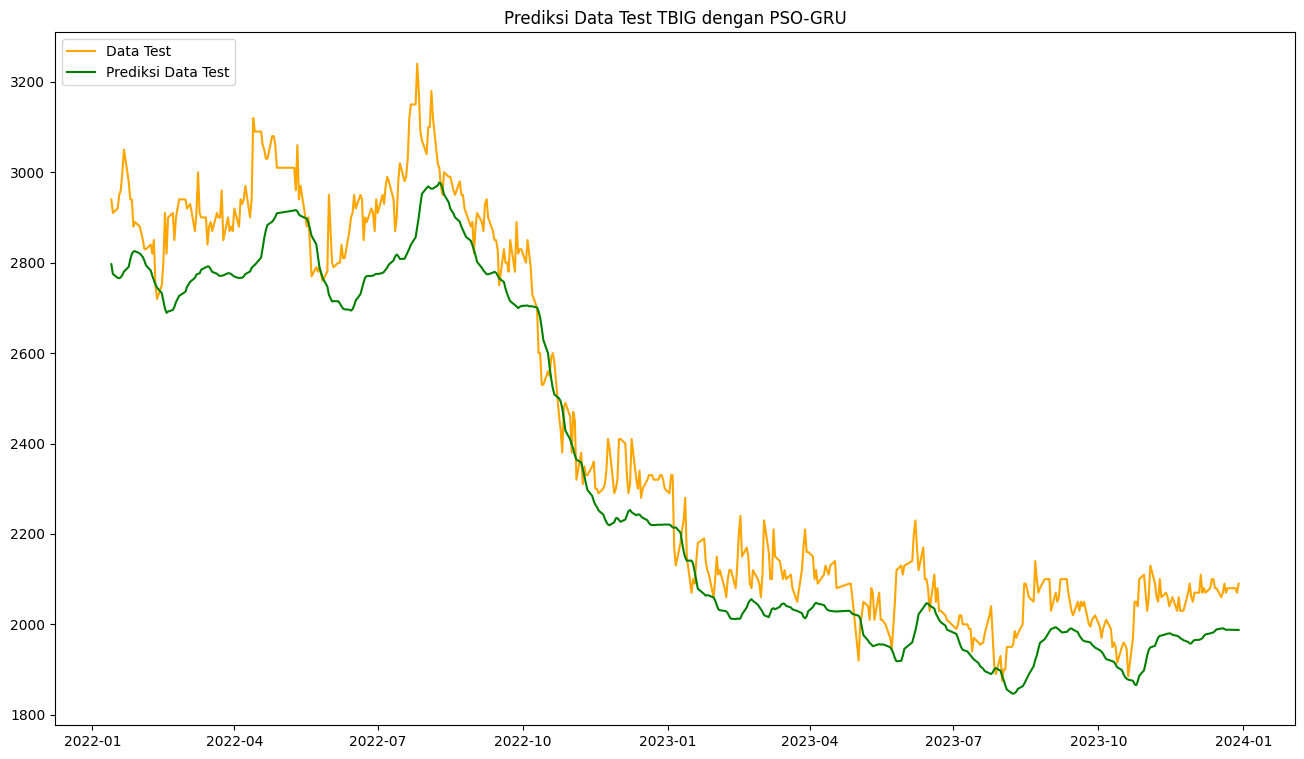

In [ ]:
#plot the predictions for test set
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data_test_psogru.index, data_test_psogru, color="orange", label='Data Test')
plt.plot(data_test_psogru.index, y_test_pred_psogru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data Test TBIG dengan PSO-GRU')
plt.legend(loc="upper left")
plot_test_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/test/tbig_test_psogru_3.png'  # Ganti dengan path dan nama file yang sesuai
plt.savefig(plot_test_psogru)
plt.show()

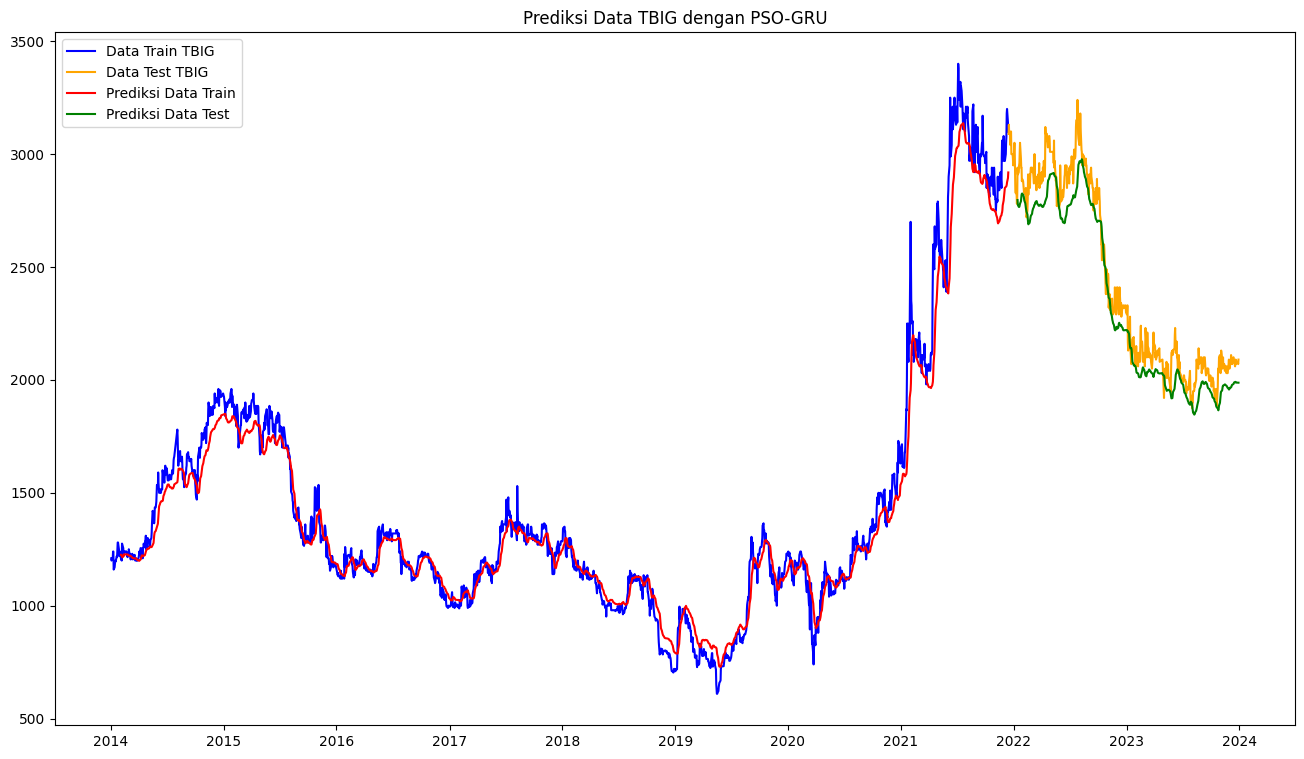

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="blue", label='Data Train TBIG')
plt.plot(df_test_tbig, color="orange", label='Data Test TBIG')
plt.plot(data_train_psogru.index, y_train_pred_psogru, color="red", label='Prediksi Data Train')
plt.plot(data_test_psogru.index, y_test_pred_psogru, color="green", label='Prediksi Data Test')
plt.title('Prediksi Data TBIG dengan PSO-GRU')
plt.legend(loc="upper left")
plot_psogru = '/content/drive/My Drive/skripsi/pso-gru/tbig/plot_psogru_3.png'
plt.savefig(plot_psogru)
plt.show()

---
## **Comparison Auto ARIMA vs LSTM vs PSO-LSTM vs GRU vs PSO-GRU**
---

### **Hyperparameter**

In [ ]:
results_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tbig/lstm_results.csv')
results_lstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.973500,91.665103,66.449873,5.266690,0.951002,89.702312,69.429296,2.755310
1,10,50,10,32,0.971403,95.221940,68.698941,5.451424,0.942167,97.455008,80.521866,3.313293
2,15,25,10,32,0.979649,80.419177,56.183235,4.290421,0.964135,76.404677,60.071142,2.489045
3,15,50,10,32,0.968148,100.609607,73.124796,5.918740,0.952068,88.327979,65.855337,2.678262
4,20,25,10,32,0.969576,98.441999,72.612357,5.928471,0.960359,80.364059,62.290407,2.567572
5,20,50,10,32,0.968914,99.507218,70.187512,5.551282,0.959982,80.745260,61.694041,2.518235


In [ ]:
results_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tbig/psolstm_results.csv')
results_psolstm

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,11,25,6,1,0.982769,73.932202,50.268917,3.670711,0.966628,73.969466,57.002119,2.304108
1,16,27,8,13,0.978813,82.074850,54.520363,4.003156,0.965656,74.769006,56.930641,2.321866
2,10,49,8,2,0.976943,85.503361,53.744261,3.584085,0.924926,111.035385,87.029829,3.367542


In [ ]:
results_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tbig/gru_results.csv')
results_gru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,10,25,10,32,0.969493,98.351403,71.908346,5.368524,0.866934,147.825935,128.755625,5.050897
1,10,50,10,32,0.983675,71.944841,53.834525,4.206077,0.966991,73.626700,55.272305,2.164895
2,15,25,10,32,0.928323,150.923939,116.630015,8.942542,0.676721,229.390620,205.132753,8.053506
3,15,50,10,32,0.981785,76.082168,54.153387,4.182694,0.958772,81.918840,65.207576,2.624319
4,20,25,10,32,0.967295,102.065306,75.752025,5.721570,0.868672,146.274661,123.625125,4.802378
5,20,50,10,32,0.976564,86.399553,60.151679,4.612343,0.951924,88.501963,72.124452,2.989947


In [ ]:
results_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tbig/psogru_results.csv')
results_psogru

,Window Size,Hidden Layers,Epochs,Batch Size,R2 Train,RMSE Train,MAE Train,MAPE Train,R2 Test,RMSE Test,MAE Test,MAPE Test
0,18,28,10,7,0.981054,77.647661,52.317602,3.919317,0.967341,72.918520,54.298202,2.182063
1,15,30,4,5,0.978158,83.313175,54.091271,3.602935,0.916815,116.361274,100.281562,4.041372
2,19,50,6,13,0.975137,88.969726,58.967570,4.076162,0.918143,115.470620,99.529343,4.062215


In [ ]:
tabel_hyperparameter = pd.DataFrame({'Model' : ['LSTM', 'PSO-LSTM', 'GRU', 'PSO-GRU'],
                                     'Window Size' : [results_lstm.loc[2, 'Window Size'], results_psolstm.loc[0, 'Window Size'], results_gru.loc[1, 'Window Size'], results_psogru.loc[0, 'Window Size']],
                                     'Hidden Layers' : [results_lstm.loc[2, 'Hidden Layers'], results_psolstm.loc[0, 'Hidden Layers'],  results_gru.loc[1, 'Hidden Layers'], results_psogru.loc[0, 'Hidden Layers']],
                                     'Epochs' : [results_lstm.loc[2, 'Epochs'], results_psolstm.loc[0, 'Epochs'], results_gru.loc[1, 'Epochs'], results_psogru.loc[0, 'Epochs']],
                                     'Batch Size' : [results_lstm.loc[2, 'Batch Size'], results_psolstm.loc[0, 'Batch Size'], results_gru.loc[1, 'Batch Size'], results_psogru.loc[0, 'Batch Size']]})
tabel_hyperparameter

,Model,Window Size,Hidden Layers,Epochs,Batch Size
0,LSTM,15,25,10,32
1,PSO-LSTM,11,25,6,1
2,GRU,10,50,10,32
3,PSO-GRU,18,28,10,7


### **Evaluasi Model**

In [ ]:
tabel_comparison_evaluasi = pd.DataFrame({'Model' : ['R2', 'RMSE',  'MAPE'],
                                          'Train Auto ARIMA' : [r2_train_autoarima, rmse_train_autoarima, mape_train_autoarima],
                                          'Test Auto ARIMA' : [r2_test_autoarima, rmse_test_autoarima, mape_test_autoarima],
                                          'Train LSTM' : [results_lstm.loc[2, 'R2 Train'], results_lstm.loc[2, 'RMSE Train'], results_lstm.loc[2, 'MAPE Train']],
                                          'Test LSTM': [results_lstm.loc[2, 'R2 Test'], results_lstm.loc[2, 'RMSE Test'], results_lstm.loc[2, 'MAPE Test']],
                                          'Train PSO-LSTM' : [results_psolstm.loc[0, 'R2 Train'], results_psolstm.loc[0, 'RMSE Train'], results_psolstm.loc[0, 'MAPE Train']],
                                          'Test PSO-LSTM': [results_psolstm.loc[0, 'R2 Test'], results_psolstm.loc[0, 'RMSE Test'], results_psolstm.loc[0, 'MAPE Test']],
                                          'Train GRU' : [results_gru.loc[1, 'R2 Train'], results_gru.loc[1, 'RMSE Train'], results_gru.loc[1, 'MAPE Train']],
                                          'Test GRU': [results_gru.loc[1, 'R2 Test'], results_gru.loc[1, 'RMSE Test'], results_gru.loc[1, 'MAPE Test']],
                                          'Train PSO-GRU' : [results_psogru.loc[0, 'R2 Train'], results_psogru.loc[0, 'RMSE Train'], results_psogru.loc[0, 'MAPE Train']],
                                          'Test PSO-GRU': [results_psogru.loc[0, 'R2 Test'], results_psogru.loc[0, 'RMSE Test'], results_psogru.loc[0, 'MAPE Test']],
                                 })
tabel_comparison_evaluasi

,Model,Train Auto ARIMA,Test Auto ARIMA,Train LSTM,Test LSTM,Train PSO-LSTM,Test PSO-LSTM,Train GRU,Test GRU,Train PSO-GRU,Test PSO-GRU
0,R2,0.992743,-2.566284,0.979649,0.964135,0.982769,0.966628,0.983675,0.966991,0.981054,0.967341
1,RMSE,47.961221,775.509635,80.419177,76.404677,73.932202,73.969466,71.944841,73.626700,77.647661,72.918520
2,MAPE,1.767579,30.446014,4.290421,2.489045,3.670711,2.304108,4.206077,2.164895,3.919317,2.182063


### **Fitted Values**

In [ ]:
fitted_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_fitted.csv', usecols=['Date','Fitted Values'])
fitted_autoarima['Date'] = pd.to_datetime(fitted_autoarima['Date'])
fitted_autoarima['Date'] = fitted_autoarima['Date'].dt.date
fitted_autoarima.set_index('Date', inplace=True)

fitted_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tbig/train/lstm_3.csv', usecols=['Date','Prediksi Data Train LSTM'])
fitted_lstm['Date'] = pd.to_datetime(fitted_lstm['Date'])
fitted_lstm['Date'] = fitted_lstm['Date'].dt.date
fitted_lstm.set_index('Date', inplace=True)

fitted_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tbig/train/psolstm_1.csv', usecols=['Date','Prediksi Data Train PSO-LSTM'])
fitted_psolstm['Date'] = pd.to_datetime(fitted_psolstm['Date'])
fitted_psolstm['Date'] = fitted_psolstm['Date'].dt.date
fitted_psolstm.set_index('Date', inplace=True)

fitted_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tbig/train/gru_2.csv', usecols=['Date','Prediksi Data Train gru'])
fitted_gru['Date'] = pd.to_datetime(fitted_gru['Date'])
fitted_gru['Date'] = fitted_gru['Date'].dt.date
fitted_gru.set_index('Date', inplace=True)

fitted_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tbig/train/psogru_1.csv', usecols=['Date','Prediksi Data Train PSO-GRU'])
fitted_psogru['Date'] = pd.to_datetime(fitted_psogru['Date'])
fitted_psogru['Date'] = fitted_psogru['Date'].dt.date
fitted_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_train_tbig, fitted_autoarima,  fitted_lstm, fitted_psolstm, fitted_gru, fitted_psogru], axis = 1)
folder_data_tlkm = '/content/drive/My Drive/skripsi/fitted_data_tlkm.csv'
tabel_comparison_prediksi.to_csv(folder_data_tlkm, index=True, mode='a')
tabel_comparison_prediksi

,TBIG,Fitted Values,Prediksi Data Train LSTM,Prediksi Data Train PSO-LSTM,Prediksi Data Train gru,Prediksi Data Train PSO-GRU
2014-01-02,1210.0,1.000000,NaN,NaN,NaN,NaN
2014-01-03,1200.0,1210.000000,NaN,NaN,NaN,NaN
2014-01-06,1210.0,1200.849982,NaN,NaN,NaN,NaN
2014-01-07,1210.0,1209.499199,NaN,NaN,NaN,NaN
2014-01-08,1240.0,1209.667030,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-08,3080.0,3044.431706,2955.8370,2924.0850,2910.7644,2920.3730
2021-12-09,3180.0,3075.160900,2963.7000,2936.3254,2917.9128,2928.2517
2021-12-10,3200.0,3169.381019,2973.6780,2942.6143,2930.5286,2938.5066
2021-12-13,3140.0,3193.896560,2989.4133,2952.7532,2958.6716,2956.4106


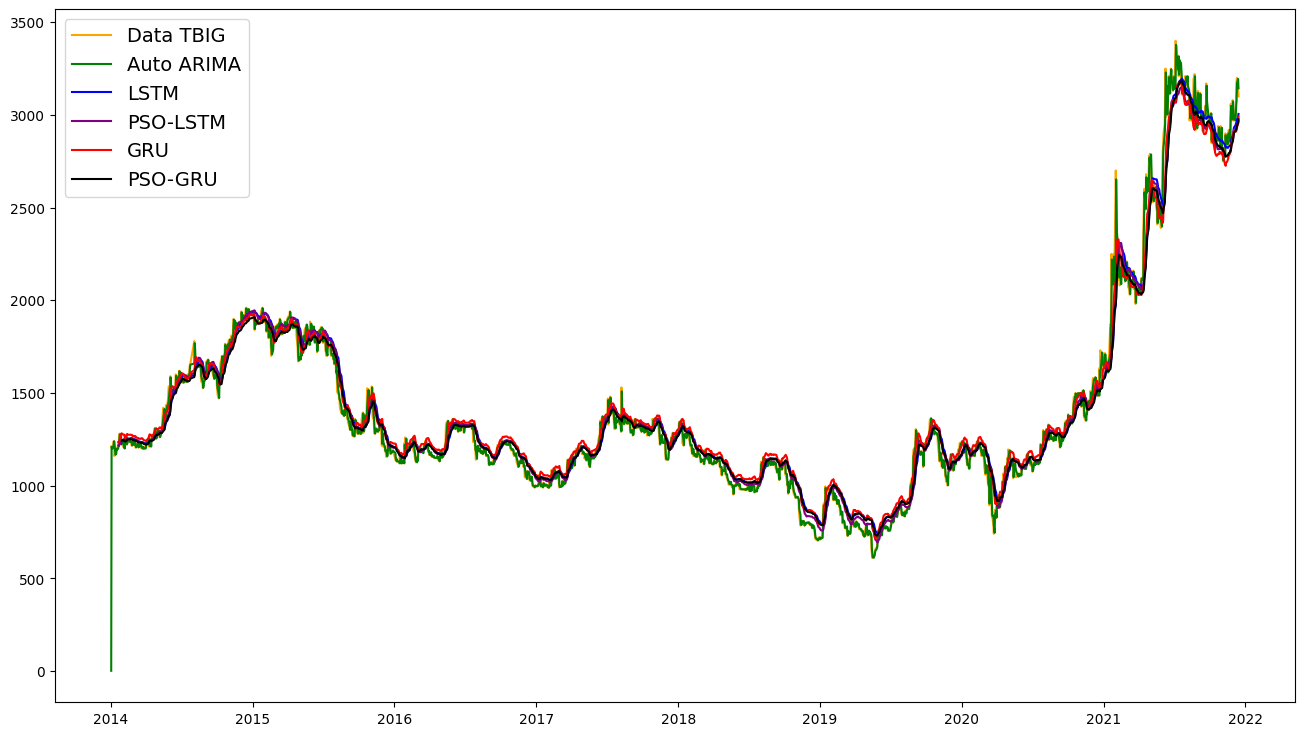

In [ ]:
#plot the fitted values
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_train_tbig, color="orange", label='Data TBIG')
plt.plot(fitted_autoarima, color="green", label='Auto ARIMA')
plt.plot(fitted_lstm, color="blue", label='LSTM')
plt.plot(fitted_psolstm, color="purple", label='PSO-LSTM')
plt.plot(fitted_gru, color="red", label='GRU')
plt.plot(fitted_psogru, color="black", label='PSO-GRU')
plt.legend(loc="upper left", fontsize=14)
plt.show()

### **Prediksi**

In [ ]:
prediksi_autoarima = pd.read_csv('/content/drive/My Drive/skripsi/auto arima/autoarima_tbig_results.csv', usecols=['Date','Prediksi Auto ARIMA'])
prediksi_autoarima['Date'] = pd.to_datetime(prediksi_autoarima['Date'], format='%Y-%m-%d')
prediksi_autoarima['Date'] = prediksi_autoarima['Date'].dt.date
prediksi_autoarima.set_index('Date', inplace=True)

prediksi_lstm = pd.read_csv('/content/drive/My Drive/skripsi/lstm/tbig/test/lstm_3.csv', usecols=['Date','Prediksi Data Test LSTM'])
prediksi_lstm['Date'] = pd.to_datetime(prediksi_lstm['Date'], format='%Y-%m-%d')
prediksi_lstm['Date'] = prediksi_lstm['Date'].dt.date
prediksi_lstm.set_index('Date', inplace=True)

prediksi_psolstm = pd.read_csv('/content/drive/My Drive/skripsi/pso-lstm/tbig/test/psolstm_1.csv', usecols=['Date','Prediksi Data Test PSO-LSTM'])
prediksi_psolstm['Date'] = pd.to_datetime(prediksi_psolstm['Date'], format='%Y-%m-%d')
prediksi_psolstm['Date'] = prediksi_psolstm['Date'].dt.date
prediksi_psolstm.set_index('Date', inplace=True)

prediksi_gru = pd.read_csv('/content/drive/My Drive/skripsi/gru/tbig/test/gru_2.csv', usecols=['Date','Prediksi Data Test GRU'])
prediksi_gru['Date'] = pd.to_datetime(prediksi_gru['Date'], format='%Y-%m-%d')
prediksi_gru['Date'] = prediksi_gru['Date'].dt.date
prediksi_gru.set_index('Date', inplace=True)

prediksi_psogru = pd.read_csv('/content/drive/My Drive/skripsi/pso-gru/tbig/test/psogru_1.csv', usecols=['Date','Prediksi Data Test PSO-GRU'])
prediksi_psogru['Date'] = pd.to_datetime(prediksi_psogru['Date'], format='%Y-%m-%d')
prediksi_psogru['Date'] = prediksi_psogru['Date'].dt.date
prediksi_psogru.set_index('Date', inplace=True)

tabel_comparison_prediksi = pd.concat([df_test_tbig, prediksi_autoarima,  prediksi_lstm, prediksi_psolstm, prediksi_gru, prediksi_psogru], axis = 1)
folder_data_tbig = '/content/drive/My Drive/skripsi/prediksi_data_tbig.csv'
tabel_comparison_prediksi.to_csv(folder_data_tbig, index=True, mode='a')
tabel_comparison_prediksi

,TBIG,Prediksi Auto ARIMA,Prediksi Data Test LSTM,Prediksi Data Test PSO-LSTM,Prediksi Data Test GRU,Prediksi Data Test PSO-GRU
2021-12-15,3090.0,3105.530385,NaN,NaN,NaN,NaN
2021-12-16,3130.0,3106.901474,NaN,NaN,NaN,NaN
2021-12-17,3090.0,3106.901474,NaN,NaN,NaN,NaN
2021-12-20,3090.0,3106.901474,NaN,NaN,NaN,NaN
2021-12-21,3040.0,3106.901474,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-21,2070.0,3106.901474,2096.9910,2093.2236,2054.9612,2054.6730
2023-12-22,2080.0,3106.901474,2098.2410,2092.0767,2056.7250,2055.8154
2023-12-27,2080.0,3106.901474,2098.4634,2091.7156,2055.3489,2055.0800
2023-12-28,2070.0,3106.901474,2098.5874,2091.6177,2055.6409,2054.9187


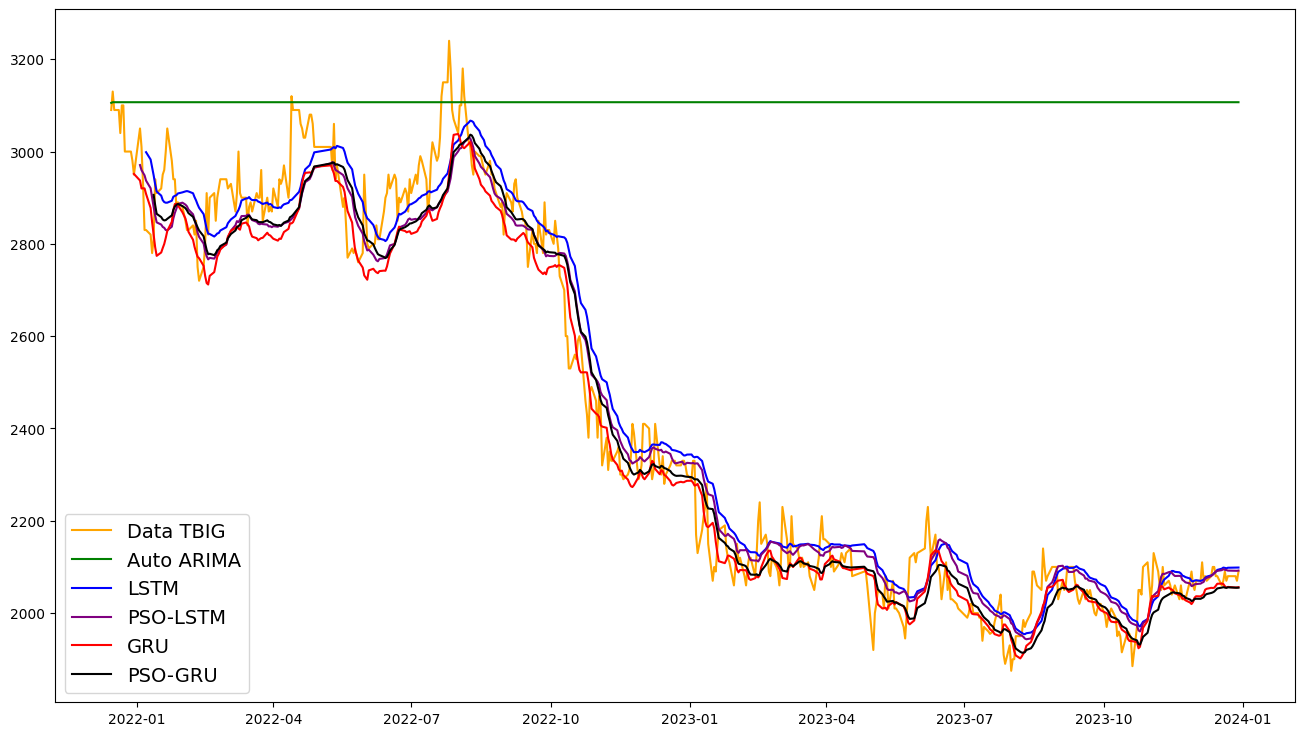

In [ ]:
#plot the predictions
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(df_test_tbig, color="orange", label='Data TBIG')
plt.plot(prediksi_autoarima, color="green", label='Auto ARIMA')
plt.plot(prediksi_lstm, color="blue", label='LSTM')
plt.plot(prediksi_psolstm, color="purple", label='PSO-LSTM')
plt.plot(prediksi_gru, color="red", label='GRU')
plt.plot(prediksi_psogru, color="black", label='PSO-GRU')
plt.legend(loc="lower left", fontsize=14)
plt.show()